# LSTM Model for Electricity Demand Forecasting




## Step 1: Import Libraries




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras for LSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Sklearn for scaling and metrics
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create output directory
import os
os.makedirs('../../saved_model_outputs/lstm_outputs', exist_ok=True)

print("Libraries imported successfully!")



Libraries imported successfully!


## Step 2: Load Data

Loading the preprocessed dataset.


In [4]:
# Load the processed dataset

possible_paths = [
    'processed_data_60min.csv',
    '../processed_data_60min/processed_data_60min.csv',
    '../../processed_data_60min.csv'
]

df = None
for data_path in possible_paths:
    try:
        # Try loading with timestamp column, fallback to first column if needed
        try:
            df = pd.read_csv(data_path, parse_dates=['utc_timestamp'], index_col='utc_timestamp')
        except (ValueError, KeyError, FileNotFoundError):
            df = pd.read_csv(data_path, parse_dates=[0], index_col=0)
            if df.index.name is None or df.index.name == 'Unnamed: 0':
                df.index.name = 'utc_timestamp'
        print(f"Data loaded from: {data_path}")
        break
    except FileNotFoundError:
        continue

if df is None:
    raise FileNotFoundError(f"Could not find data file. Tried: {possible_paths}")

print(f"Data loaded! Shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Total columns: {len(df.columns)}")
print(f"\nFirst few columns: {list(df.columns[:5])}")


Data loaded from: ../processed_data_60min/processed_data_60min.csv
Data loaded! Shape: (32688, 83)
Date range: 2015-01-08 00:00:00+00:00 to 2018-09-30 23:00:00+00:00
Total columns: 83

First few columns: ['target_load', 'DE_50hertz_load_actual_entsoe_transparency', 'DE_amprion_load_actual_entsoe_transparency', 'DE_tennet_load_actual_entsoe_transparency', 'DE_transnetbw_load_actual_entsoe_transparency']


## Step 3: Prepare Features and Target




In [5]:
# Get target and features
target = df['target_load'].copy()

# Exclude target and timestamp-related columns from features
feature_cols = [col for col in df.columns if col != 'target_load']
features = df[feature_cols].copy()

print(f"Target shape: {target.shape}")
print(f"Features shape: {features.shape}")
print(f"\nNumber of features: {len(feature_cols)}")

# Check for any missing values (shouldn't be any after preprocessing)
if features.isnull().sum().sum() > 0:
    print("\nWarning: Found missing values in features!")
    print(features.isnull().sum().sum())
else:
    print("\nNo missing values in features")


Target shape: (32688,)
Features shape: (32688, 82)

Number of features: 82

No missing values in features


## Step 4: Train/Validation/Test Split

Splitting the data:
- Train: 2015-01-08 to 2017-12-31
- Validation: Using part of training for early stopping (2017 data)
- Test: 2018-01-01 to 2018-09-30


In [6]:
# Split by dates
train_end_date = '2017-12-31 23:00:00'
test_start_date = '2018-01-01 00:00:00'

train_data_full = df[:train_end_date].copy()  # 2015-2017
test_data = df[test_start_date:].copy()  # 2018

# For validation, split the training data internally (use last 20% of training period)
n_train_full = len(train_data_full)
val_split_idx = int(0.80 * n_train_full)  # Use 80% for training, 20% for validation

train_data_only = train_data_full.iloc[:val_split_idx].copy()
val_data = train_data_full.iloc[val_split_idx:].copy()

# Extract features and target
X_train = train_data_only[feature_cols].values
y_train = train_data_only['target_load'].values

X_val = val_data[feature_cols].values
y_val = val_data['target_load'].values

X_test = test_data[feature_cols].values
y_test = test_data['target_load'].values

print("="*80)
print("TRAIN/VALIDATION/TEST SPLIT")
print("="*80)
print(f"Full training period: {train_data_full.index.min()} to {train_data_full.index.max()}")
print(f"  Total training samples: {len(train_data_full):,}")
print(f"\n  Train subset: {train_data_only.index.min()} to {train_data_only.index.max()}")
print(f"     Samples: {X_train.shape[0]:,} ({X_train.shape[0]/len(train_data_full)*100:.1f}% of training period)")
print(f"\n  Validation subset: {val_data.index.min()} to {val_data.index.max()}")
print(f"     Samples: {X_val.shape[0]:,} ({X_val.shape[0]/len(train_data_full)*100:.1f}% of training period)")
print(f"\nTest set: {test_data.index.min()} to {test_data.index.max()}")
print(f"  Samples: {X_test.shape[0]:,} ({X_test.shape[0]/len(df)*100:.1f}% of full dataset)")


TRAIN/VALIDATION/TEST SPLIT
Full training period: 2015-01-08 00:00:00+00:00 to 2017-12-31 23:00:00+00:00
  Total training samples: 26,136

  Train subset: 2015-01-08 00:00:00+00:00 to 2017-05-28 03:00:00+00:00
     Samples: 20,908 (80.0% of training period)

  Validation subset: 2017-05-28 04:00:00+00:00 to 2017-12-31 23:00:00+00:00
     Samples: 5,228 (20.0% of training period)

Test set: 2018-01-01 00:00:00+00:00 to 2018-09-30 23:00:00+00:00
  Samples: 6,552 (20.0% of full dataset)


## Step 5: Scale the Data




In [7]:
# Scale features (using RobustScaler like in preprocessing)
feature_scaler = RobustScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_val_scaled = feature_scaler.transform(X_val)
X_test_scaled = feature_scaler.transform(X_test)

# Scale target (using MinMaxScaler for LSTM - works better than RobustScaler)
target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = target_scaler.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).flatten()

print(f"Features scaled. Train shape: {X_train_scaled.shape}")
print(f"Target scaled. Train shape: {y_train_scaled.shape}")
print(f"\nTarget scaler - Min: {target_scaler.data_min_[0]:.2f}, Max: {target_scaler.data_max_[0]:.2f}")


Features scaled. Train shape: (20908, 82)
Target scaled. Train shape: (20908,)

Target scaler - Min: 31307.00, Max: 76602.00


## Step 6: Create Sequences for LSTM




In [8]:
def create_sequences(X, y, seq_length=24):
    """
    Create sequences for LSTM.
    seq_length: number of time steps to look back
    """
    X_seq, y_seq = [], []
    
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    
    return np.array(X_seq), np.array(y_seq)

# Create sequences
seq_length = 24  # 24 hours = 1 day

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_length)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_length)

print(f"Sequence length: {seq_length} hours")
print(f"\nTrain sequences: {X_train_seq.shape}")
print(f"Validation sequences: {X_val_seq.shape}")
print(f"Test sequences: {X_test_seq.shape}")
print(f"\nEach sequence: {seq_length} time steps × {X_train_seq.shape[2]} features")


Sequence length: 24 hours

Train sequences: (20884, 24, 82)
Validation sequences: (5204, 24, 82)
Test sequences: (6528, 24, 82)

Each sequence: 24 time steps × 82 features


## Step 7: Build LSTM Model

Building the LSTM architecture. Starting with a simple model:
- Input layer 
- 2 LSTM layers with dropout to prevent overfitting
- Dense output layer




In [9]:
# Model parameters
n_features = X_train_seq.shape[2]
lstm_units_1 = 64  # First LSTM layer
lstm_units_2 = 32  # Second LSTM layer
dropout_rate = 0.2  # Dropout to prevent overfitting

# Build model
model = Sequential([
    Input(shape=(seq_length, n_features)),
    LSTM(lstm_units_1, return_sequences=True, dropout=dropout_rate),
    LSTM(lstm_units_2, return_sequences=False, dropout=dropout_rate),
    Dense(16, activation='relu'),
    Dropout(dropout_rate),
    Dense(1)  # Output: single value (next hour's load)
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',  # Mean Squared Error
    metrics=['mae']  # Mean Absolute Error
)

# Show model architecture
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        37,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,593 (197.63 KB)

 Trainable params: 50,593 (197.63 KB)

 Non-trainable params: 0 (0.00 B)

## Step 8: Set Up Callbacks




In [10]:
# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,  # Stop if no improvement for 10 epochs
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,  # Reduce LR by half
        patience=5,  # Wait 5 epochs
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        '../../saved_model_outputs/lstm_outputs/best_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

print("Callbacks configured:")
print("- Early stopping (patience=10)")
print("- Learning rate reduction (patience=5)")
print("- Model checkpointing")


Callbacks configured:
- Early stopping (patience=10)
- Learning rate reduction (patience=5)
- Model checkpointing


## Step 9: Train the Model



In [11]:
# Training parameters
batch_size = 64
epochs = 100  # Max epochs (will stop early if needed)

print("="*80)
print("STARTING TRAINING")
print("="*80)
print(f"Batch size: {batch_size}")
print(f"Max epochs: {epochs}")
print("Training will stop early if validation loss doesn't improve.")
print("="*80)

# Train model
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*80)
print("TRAINING COMPLETED!")
print("="*80)


STARTING TRAINING
Batch size: 64
Max epochs: 100
Training will stop early if validation loss doesn't improve.
Epoch 1/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0525 - mae: 0.1652
Epoch 1: val_loss improved from None to 0.00484, saving model to ../../saved_model_outputs/lstm_outputs/best_model.h5



Epoch 1: finished saving model to ../../saved_model_outputs/lstm_outputs/best_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.0270 - mae: 0.1212 - val_loss: 0.0048 - val_mae: 0.0549 - learning_rate: 0.0010
Epoch 2/100
325/327 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0120 - mae: 0.0835
Epoch 2: val_loss improved from 0.00484 to 0.00183, saving model to ../../saved_model_outputs/lstm_outputs/best_model.h5



Epoch 2: finished saving model to ../../saved_model_outputs/lstm_outputs/best_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0108 - mae: 0.0796 - val_loss: 0.0018 - val_mae: 0.0330 - learning_rate: 0.0010
Epoch 3/100
324/327 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0085 - mae: 0.0704
Epoch 3: val_loss did not improve from 0.00183
327/327 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0080 - mae: 0.0680 - val_loss: 0.0020 - val_mae: 0.0333 - learning_rate: 0.0010
Epoch 4/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0067 - mae: 0.0619
Epoch 4: val_loss improved from 0.00183 to 0.00125, saving model to ../../saved_model_outputs/lstm_outputs/best_model.h5



Epoch 4: finished saving model to ../../saved_model_outputs/lstm_outputs/best_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0063 - mae: 0.0597 - val_loss: 0.0012 - val_mae: 0.0265 - learning_rate: 0.0010
Epoch 5/100
325/327 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0054 - mae: 0.0555
Epoch 5: val_loss improved from 0.00125 to 0.00109, saving model to ../../saved_model_outputs/lstm_outputs/best_model.h5



Epoch 5: finished saving model to ../../saved_model_outputs/lstm_outputs/best_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0052 - mae: 0.0543 - val_loss: 0.0011 - val_mae: 0.0253 - learning_rate: 0.0010
Epoch 6/100
325/327 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0047 - mae: 0.0522
Epoch 6: val_loss improved from 0.00109 to 0.00084, saving model to ../../saved_model_outputs/lstm_outputs/best_model.h5



Epoch 6: finished saving model to ../../saved_model_outputs/lstm_outputs/best_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0044 - mae: 0.0507 - val_loss: 8.4088e-04 - val_mae: 0.0221 - learning_rate: 0.0010
Epoch 7/100
324/327 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0040 - mae: 0.0482
Epoch 7: val_loss did not improve from 0.00084
327/327 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0040 - mae: 0.0479 - val_loss: 9.0271e-04 - val_mae: 0.0227 - learning_rate: 0.0010
Epoch 8/100
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0037 - mae: 0.0469
Epoch 8: val_loss did not improve from 0.00084
327/327 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0038 - mae: 0.0470 - val_loss: 0.0010 - val_mae: 0.0241 - learning_rate: 0.0010
Epoch 9/100
323/327 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0037 - mae: 0.0459
Epoch 9: val_loss did not improve from 0.00084
327/327 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0036 - mae: 0.0457 - val_loss: 0.0010 - val_mae: 0.0245 - learning


Epoch 10: finished saving model to ../../saved_model_outputs/lstm_outputs/best_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0036 - mae: 0.0454 - val_loss: 7.9598e-04 - val_mae: 0.0213 - learning_rate: 0.0010
Epoch 11/100
325/327 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0035 - mae: 0.0447
Epoch 11: val_loss improved from 0.00080 to 0.00059, saving model to ../../saved_model_outputs/lstm_outputs/best_model.h5



Epoch 11: finished saving model to ../../saved_model_outputs/lstm_outputs/best_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0035 - mae: 0.0445 - val_loss: 5.9218e-04 - val_mae: 0.0191 - learning_rate: 0.0010
Epoch 12/100
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0034 - mae: 0.0440
Epoch 12: val_loss improved from 0.00059 to 0.00053, saving model to ../../saved_model_outputs/lstm_outputs/best_model.h5



Epoch 12: finished saving model to ../../saved_model_outputs/lstm_outputs/best_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0034 - mae: 0.0442 - val_loss: 5.3448e-04 - val_mae: 0.0176 - learning_rate: 0.0010
Epoch 13/100
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0033 - mae: 0.0437
Epoch 13: val_loss did not improve from 0.00053
327/327 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0033 - mae: 0.0432 - val_loss: 5.8917e-04 - val_mae: 0.0182 - learning_rate: 0.0010
Epoch 14/100
324/327 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0033 - mae: 0.0433
Epoch 14: val_loss did not improve from 0.00053
327/327 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0033 - mae: 0.0429 - val_loss: 8.2498e-04 - val_mae: 0.0221 - learning_rate: 0.0010
Epoch 15/100
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0032 - mae: 0.0427
Epoch 15: val_loss improved from 0.00053 to 0.00052, saving model to ../../saved_model_outputs/lstm_outputs/best_model.h5



Epoch 15: finished saving model to ../../saved_model_outputs/lstm_outputs/best_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0032 - mae: 0.0426 - val_loss: 5.2039e-04 - val_mae: 0.0170 - learning_rate: 0.0010
Epoch 16/100
325/327 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0032 - mae: 0.0422
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 16: val_loss did not improve from 0.00052
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0032 - mae: 0.0421 - val_loss: 5.2786e-04 - val_mae: 0.0178 - learning_rate: 0.0010
Epoch 17/100
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0413
Epoch 17: val_loss did not improve from 0.00052
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0030 - mae: 0.0410 - val_loss: 5.4561e-04 - val_mae: 0.0181 - learning_rate: 5.0000e-04
Epoch 18/100
323/327 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029 - mae: 0.0407
Epoch 18: val_loss did not improve from 0.00052
327/327 ━━━━━━━━━━━━━━━━━


Epoch 22: finished saving model to ../../saved_model_outputs/lstm_outputs/best_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0029 - mae: 0.0399 - val_loss: 4.9300e-04 - val_mae: 0.0171 - learning_rate: 2.5000e-04
Epoch 23/100
324/327 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028 - mae: 0.0397
Epoch 23: val_loss did not improve from 0.00049
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0028 - mae: 0.0396 - val_loss: 4.9807e-04 - val_mae: 0.0171 - learning_rate: 2.5000e-04
Epoch 24/100
325/327 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029 - mae: 0.0400
Epoch 24: val_loss improved from 0.00049 to 0.00046, saving model to ../../saved_model_outputs/lstm_outputs/best_model.h5



Epoch 24: finished saving model to ../../saved_model_outputs/lstm_outputs/best_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0029 - mae: 0.0397 - val_loss: 4.6204e-04 - val_mae: 0.0164 - learning_rate: 2.5000e-04
Epoch 25/100
324/327 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0029 - mae: 0.0398
Epoch 25: val_loss did not improve from 0.00046
327/327 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0029 - mae: 0.0397 - val_loss: 4.9209e-04 - val_mae: 0.0169 - learning_rate: 2.5000e-04
Epoch 26/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0029 - mae: 0.0401
Epoch 26: val_loss did not improve from 0.00046
327/327 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0029 - mae: 0.0402 - val_loss: 5.5581e-04 - val_mae: 0.0185 - learning_rate: 2.5000e-04
Epoch 27/100
324/327 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028 - mae: 0.0394
Epoch 27: val_loss did not improve from 0.00046
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0028 - mae: 0.0393 - val_loss: 4.6762e-04 -


Epoch 30: finished saving model to ../../saved_model_outputs/lstm_outputs/best_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0028 - mae: 0.0394 - val_loss: 4.3155e-04 - val_mae: 0.0157 - learning_rate: 1.2500e-04
Epoch 31/100
324/327 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0028 - mae: 0.0390
Epoch 31: val_loss did not improve from 0.00043
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0028 - mae: 0.0391 - val_loss: 4.5172e-04 - val_mae: 0.0161 - learning_rate: 1.2500e-04
Epoch 32/100
325/327 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0028 - mae: 0.0393
Epoch 32: val_loss did not improve from 0.00043
327/327 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0028 - mae: 0.0390 - val_loss: 4.7466e-04 - val_mae: 0.0165 - learning_rate: 1.2500e-04
Epoch 33/100
323/327 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028 - mae: 0.0390
Epoch 33: val_loss did not improve from 0.00043
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0028 - mae: 0.0392 - val_loss: 4.6112e-04 -

## Step 10: Plot Training 

Plotting training to see how the model learned - checking if it's overfitting or underfitting.


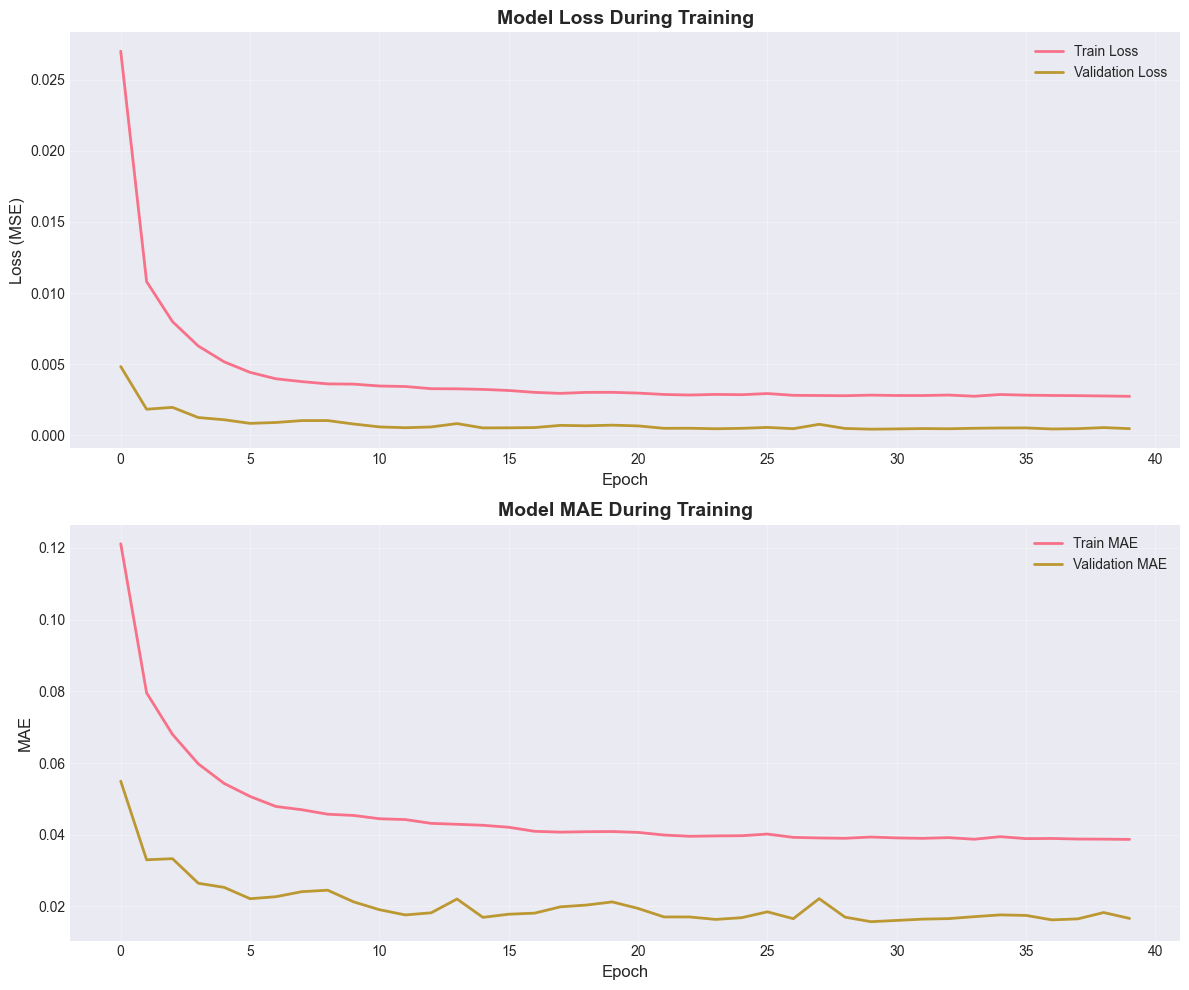

Training history saved!


In [12]:
# Plot training history
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss During Training', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Train MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_title('Model MAE During Training', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../../saved_model_outputs/lstm_outputs/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training history saved!")


## Step 11: Make Predictions

Making predictions on the test set to see how well the model performs.


In [13]:
# Load best model 
try:
    model.load_weights('../../saved_model_outputs/lstm_outputs/best_model.h5')
    print("Loaded best model weights")
except:
    print("Using current model weights")

# Predictions on test set
print("Making predictions on test set...")
y_pred_scaled = model.predict(X_test_seq, verbose=0)

# Transform back to original scale
y_pred = target_scaler.inverse_transform(y_pred_scaled).flatten()

# Actual values
y_test_actual = y_test[seq_length:]

print(f"\nPredictions shape: {y_pred.shape}")
print(f"Actual values shape: {y_test_actual.shape}")
print(f"\nPrediction summary:")
print(f"  Min predicted: {y_pred.min():,.2f} MW")
print(f"  Max predicted: {y_pred.max():,.2f} MW")
print(f"  Mean predicted: {y_pred.mean():,.2f} MW")
print(f"\nActual summary:")
print(f"  Min actual: {y_test_actual.min():,.2f} MW")
print(f"  Max actual: {y_test_actual.max():,.2f} MW")
print(f"  Mean actual: {y_test_actual.mean():,.2f} MW")


Loaded best model weights
Making predictions on test set...

Predictions shape: (6528,)
Actual values shape: (6528,)

Prediction summary:
  Min predicted: 37,001.77 MW
  Max predicted: 73,740.19 MW
  Mean predicted: 56,387.04 MW

Actual summary:
  Min actual: 35,118.00 MW
  Max actual: 75,964.00 MW
  Mean actual: 56,620.43 MW


## Step 12: Evaluate Model Performance

Calculating performance metrics:
- MAE, RMSE, MAPE
- Mean Error
- MASE 
- R²
- Directional Accuracy
- Accuracy (percentage of correct predictions within 5% error)


In [14]:
# Calculate metrics
def calculate_metrics(actual, forecast):
    
    # Remove any NaN values
    mask = ~(np.isnan(actual) | np.isnan(forecast))
    actual_clean = actual[mask]
    forecast_clean = forecast[mask]
    
    # Mean Absolute Error (MAE)
    mae = np.mean(np.abs(actual_clean - forecast_clean))
    
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(np.mean((actual_clean - forecast_clean)**2))
    
    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((actual_clean - forecast_clean) / actual_clean)) * 100
    
    # Mean Error (Bias)
    me = np.mean(forecast_clean - actual_clean)
    
    # Mean Absolute Scaled Error (MASE)
    naive_forecast = np.roll(actual_clean, 1)
    naive_forecast[0] = actual_clean[0]  
    naive_error = np.mean(np.abs(actual_clean - naive_forecast))
    mase = mae / naive_error if naive_error > 0 else np.nan
    
    # R-squared
    ss_res = np.sum((actual_clean - forecast_clean)**2)
    ss_tot = np.sum((actual_clean - np.mean(actual_clean))**2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else np.nan
    
    # Directional Accuracy 
    actual_diff = np.diff(actual_clean)
    forecast_diff = np.diff(forecast_clean)
    directional_accuracy = np.mean((actual_diff * forecast_diff) > 0) * 100
    
    # Accuracy: Percentage of correct predictions (within 5% error threshold)
    pct_errors = np.abs((actual_clean - forecast_clean) / actual_clean) * 100
    accuracy = np.mean(pct_errors <= 5.0) * 100  # Accuracy = correct predictions / total predictions * 100
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'ME': me,
        'MASE': mase,
        'R2': r2,
        'Directional Accuracy': directional_accuracy,
        'Accuracy': accuracy
    }

# Calculate metrics
metrics = calculate_metrics(y_test_actual, y_pred)

print("="*80)
print("MODEL PERFORMANCE METRICS")
print("="*80)
print(f"\nMean Absolute Error (MAE): {metrics['MAE']:,.2f} MW")
print(f"Root Mean Squared Error (RMSE): {metrics['RMSE']:,.2f} MW")
print(f"Mean Absolute Percentage Error (MAPE): {metrics['MAPE']:.2f}%")
print(f"Mean Error (Bias): {metrics['ME']:,.2f} MW")
print(f"Mean Absolute Scaled Error (MASE): {metrics['MASE']:.4f}")
print(f"R-squared (R²): {metrics['R2']:.4f}")
print(f"Directional Accuracy: {metrics['Directional Accuracy']:.2f}%")
print(f"Accuracy (within 5% error): {metrics['Accuracy']:.2f}%")

# Save metrics
metrics_dict = {k: float(v) if not np.isnan(v) else None for k, v in metrics.items()}
metrics_dict['train_period'] = f"{train_data_full.index.min()} to {train_data_full.index.max()}"
metrics_dict['train_subset_period'] = f"{train_data_only.index.min()} to {train_data_only.index.max()}"
metrics_dict['val_period'] = f"{val_data.index.min()} to {val_data.index.max()}"
metrics_dict['test_period'] = f"{test_data.index.min()} to {test_data.index.max()}"
metrics_dict['n_train_full'] = len(train_data_full)
metrics_dict['n_train'] = len(X_train)
metrics_dict['n_val'] = len(X_val)
metrics_dict['n_test'] = len(X_test)

import json
with open('../../saved_model_outputs/lstm_outputs/metrics.json', 'w') as f:
    json.dump(metrics_dict, f, indent=2)

print("\nMetrics saved to ../../saved_model_outputs/lstm_outputs/metrics.json")


MODEL PERFORMANCE METRICS

Mean Absolute Error (MAE): 764.96 MW
Root Mean Squared Error (RMSE): 989.54 MW
Mean Absolute Percentage Error (MAPE): 1.37%
Mean Error (Bias): -233.38 MW
Mean Absolute Scaled Error (MASE): 0.4007
R-squared (R²): 0.9898
Directional Accuracy: 91.14%
Accuracy (within 5% error): 98.87%

Metrics saved to ../../saved_model_outputs/lstm_outputs/metrics.json


## Step 13: Visualize Predictions

Plotting the predictions vs actual values to see how well it's doing visually.


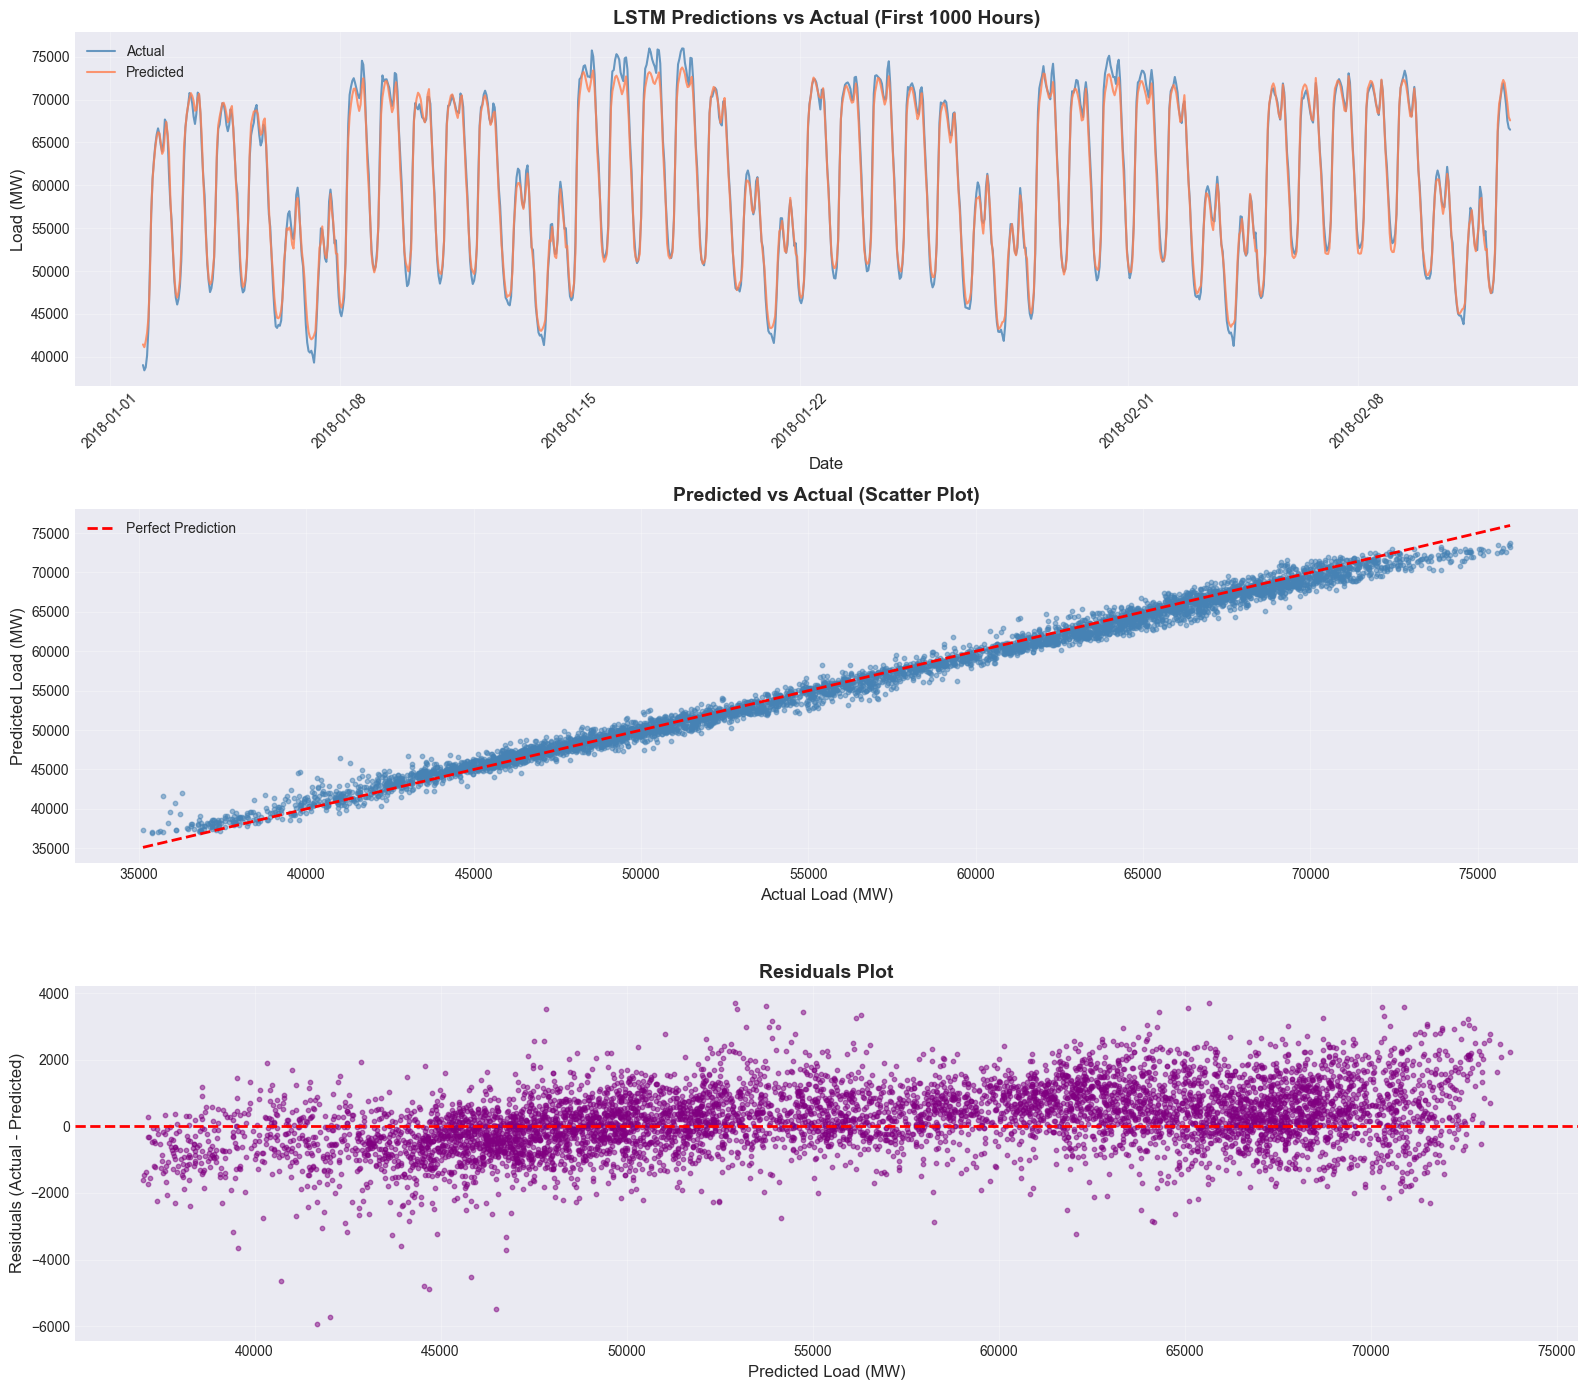

Visualizations saved!


In [15]:
# Get test dates
test_dates = test_data.index[seq_length:seq_length + len(y_pred)]

# Create visualizations
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# 1. Time series plot (first 1000 hours)
plot_length = min(1000, len(y_pred))
axes[0].plot(test_dates[:plot_length], y_test_actual[:plot_length], 
            label='Actual', linewidth=1.5, alpha=0.8, color='steelblue')
axes[0].plot(test_dates[:plot_length], y_pred[:plot_length], 
            label='Predicted', linewidth=1.5, alpha=0.8, color='coral')
axes[0].set_title('LSTM Predictions vs Actual (First 1000 Hours)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Load (MW)', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# 2. Scatter plot
sample_size = min(5000, len(y_pred))
sample_idx = np.random.choice(len(y_pred), sample_size, replace=False)
axes[1].scatter(y_test_actual[sample_idx], y_pred[sample_idx], 
               alpha=0.5, s=10, color='steelblue')
axes[1].plot([y_test_actual.min(), y_test_actual.max()], 
           [y_test_actual.min(), y_test_actual.max()], 
           'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_title('Predicted vs Actual (Scatter Plot)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Actual Load (MW)', fontsize=12)
axes[1].set_ylabel('Predicted Load (MW)', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)

# 3. Residuals plot
residuals = y_test_actual - y_pred
axes[2].scatter(y_pred, residuals, alpha=0.5, s=10, color='purple')
axes[2].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[2].set_title('Residuals Plot', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Predicted Load (MW)', fontsize=12)
axes[2].set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../../saved_model_outputs/lstm_outputs/predictions_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualizations saved!")


## Step 14: Peak Load Performance

Check how well the model predicts peak loads (the most important periods).


In [16]:
# Define peak threshold
peak_threshold = np.percentile(y_test_actual, 90)
is_peak = y_test_actual >= peak_threshold

# Calculate metrics for peak vs non-peak
peak_mae = mean_absolute_error(y_test_actual[is_peak], y_pred[is_peak])
peak_rmse = np.sqrt(mean_squared_error(y_test_actual[is_peak], y_pred[is_peak]))

non_peak_mae = mean_absolute_error(y_test_actual[~is_peak], y_pred[~is_peak])
non_peak_rmse = np.sqrt(mean_squared_error(y_test_actual[~is_peak], y_pred[~is_peak]))

print("="*80)
print("PEAK LOAD PERFORMANCE")
print("="*80)
print(f"\nPeak threshold (90th percentile): {peak_threshold:,.2f} MW")
print(f"Number of peak hours: {is_peak.sum():,} ({is_peak.sum()/len(is_peak)*100:.1f}%)")
print(f"\nPeak Load Metrics:")
print(f"  MAE: {peak_mae:,.2f} MW")
print(f"  RMSE: {peak_rmse:,.2f} MW")
print(f"\nNon-Peak Load Metrics:")
print(f"  MAE: {non_peak_mae:,.2f} MW")
print(f"  RMSE: {non_peak_rmse:,.2f} MW")
print(f"\nPeak/Non-Peak Error Ratio:")
print(f"  MAE ratio: {peak_mae/non_peak_mae:.2f}x")
print(f"  RMSE ratio: {peak_rmse/non_peak_rmse:.2f}x")


PEAK LOAD PERFORMANCE

Peak threshold (90th percentile): 69,295.30 MW
Number of peak hours: 653 (10.0%)

Peak Load Metrics:
  MAE: 1,150.82 MW
  RMSE: 1,380.49 MW

Non-Peak Load Metrics:
  MAE: 722.07 MW
  RMSE: 936.05 MW

Peak/Non-Peak Error Ratio:
  MAE ratio: 1.59x
  RMSE ratio: 1.47x


## Step 15: Save Predictions

Save the predictions to a CSV file for further analysis.


In [17]:
# Create predictions dataframe
predictions_df = pd.DataFrame({
    'date': test_dates,
    'actual': y_test_actual,
    'predicted': y_pred,
    'error': y_test_actual - y_pred,
    'abs_error': np.abs(y_test_actual - y_pred),
    'is_peak': is_peak
})

# Save to CSV
predictions_df.to_csv('../../saved_model_outputs/lstm_outputs/lstm_predictions.csv', index=False)

print(f"Predictions saved to ../../saved_model_outputs/lstm_outputs/lstm_predictions.csv")
print(f"\nFirst few predictions:")
print(predictions_df.head(10))


Predictions saved to ../../saved_model_outputs/lstm_outputs/lstm_predictions.csv

First few predictions:
                       date   actual     predicted        error    abs_error  \
0 2018-01-02 00:00:00+00:00  39033.0  41442.671875 -2409.671875  2409.671875   
1 2018-01-02 01:00:00+00:00  38421.0  41119.800781 -2698.800781  2698.800781   
2 2018-01-02 02:00:00+00:00  38771.0  41811.851562 -3040.851562  3040.851562   
3 2018-01-02 03:00:00+00:00  40156.0  42803.664062 -2647.664062  2647.664062   
4 2018-01-02 04:00:00+00:00  43366.0  44565.648438 -1199.648438  1199.648438   
5 2018-01-02 05:00:00+00:00  49805.0  48869.269531   935.730469   935.730469   
6 2018-01-02 06:00:00+00:00  56567.0  56785.824219  -218.824219   218.824219   
7 2018-01-02 07:00:00+00:00  60770.0  60651.636719   118.363281   118.363281   
8 2018-01-02 08:00:00+00:00  62933.0  62741.468750   191.531250   191.531250   
9 2018-01-02 09:00:00+00:00  64678.0  64419.812500   258.187500   258.187500   

   is_peak  
0

## Step 16: SHAP Analysis for Model Explainability

Using SHAP (SHapley Additive exPlanations) to understand which features contribute most to LSTM predictions. This helps explain the model's decision-making process.


In [18]:
# Install shap if not available
try:
    import shap
    print("SHAP library imported successfully!")
except ImportError:
    print("Installing SHAP...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap"])
    import shap
    print("SHAP installed and imported!")

import warnings
warnings.filterwarnings('ignore')

print(f"SHAP version: {shap.__version__}")


SHAP library imported successfully!
SHAP version: 0.50.0


In [19]:

# SHAP Analysis for LSTM Model

# For LSTM models, we'll use SHAP's KernelExplainer
# Since LSTM uses sequences, we'll aggregate SHAP values across time steps.

print("="*80)
print("SHAP ANALYSIS FOR LSTM MODEL")
print("="*80)

# Ensure model is loaded
try:
    model.load_weights('../../saved_model_outputs/lstm_outputs/best_model.h5')
    print("✓ Model loaded successfully")
except:
    print("Using current model weights")

print(f"\nModel architecture:")
print(f"  Input shape: (batch, {seq_length}, {n_features})")
print(f"  Sequence length: {seq_length} hours")
print(f"  Number of features: {n_features}")
print(f"  Feature names: {len(feature_cols)} features")


SHAP ANALYSIS FOR LSTM MODEL
✓ Model loaded successfully

Model architecture:
  Input shape: (batch, 24, 82)
  Sequence length: 24 hours
  Number of features: 82
  Feature names: 82 features


In [20]:
# Prepare background and test samples for SHAP

background_size = min(100, len(X_train_seq))  # Background samples
test_sample_size = min(300, len(X_test_seq))  # Test samples for SHAP

# Sample background data
np.random.seed(42)
bg_indices = np.random.choice(len(X_train_seq), background_size, replace=False)
test_indices = np.random.choice(len(X_test_seq), test_sample_size, replace=False)

X_background = X_train_seq[bg_indices]
X_test_sample = X_test_seq[test_indices]

print(f"Background samples: {X_background.shape}")
print(f"Test samples for SHAP: {X_test_sample.shape}")


Background samples: (100, 24, 82)
Test samples for SHAP: (300, 24, 82)


In [21]:

# KernelExplainer 

print("\n" + "="*80)
print("Creating SHAP KernelExplainer")


def model_predict_wrapper(X_flat):
    # Handle both 1D and 2D inputs
    if len(X_flat.shape) == 1:
        # If 1D, reshape to (1, seq_length, n_features)
        X_reshaped = X_flat.reshape(1, seq_length, n_features)
        n_samples = 1
    else:
        # If 2D, reshape each row
        n_samples = X_flat.shape[0]
        X_reshaped = X_flat.reshape(n_samples, seq_length, n_features)
    
    # Ensure input is float32 for TensorFlow compatibility
    X_reshaped = X_reshaped.astype(np.float32)
    
    # Make predictions (returns scaled values in 0-1 range)
    predictions = model(X_reshaped, training=False).numpy()
    
    # Ensure output is 1D and properly shaped
    predictions_flat = predictions.flatten()
    
    # Return flattened predictions 
    return predictions_flat


kernel_bg_size = len(X_background)  # Use all background samples (100)
X_background_kernel = X_background[:kernel_bg_size]

# Flatten background data for KernelExplainer
X_background_flat = X_background_kernel.reshape(kernel_bg_size, -1).astype(np.float32)

print(f"Using {kernel_bg_size} background samples for KernelExplainer (increased for accuracy)")
print(f"Background shape (flattened): {X_background_flat.shape}")

# Create explainer using KernelExplainer
explainer = shap.KernelExplainer(model_predict_wrapper, X_background_flat)

print("SHAP KernelExplainer created successfully!")




Creating SHAP KernelExplainer
Using 100 background samples for KernelExplainer (increased for accuracy)
Background shape (flattened): (100, 1968)
SHAP KernelExplainer created successfully!


In [22]:
# Compute SHAP Values 

print("\n" + "="*80)
print("Computing SHAP values (this may take 10-20 minutes with KernelExplainer)...")


# Flatten test samples for KernelExplainer
X_test_sample_flat = X_test_sample.reshape(len(X_test_sample), -1).astype(np.float32)

print(f"Test sample shape (flattened): {X_test_sample_flat.shape}")
print(f"Computing SHAP values for {len(X_test_sample)} samples...")
print(f"Using nsamples=200 for better accuracy (increased from 100)")

# Compute SHAP values
shap_values_flat = explainer.shap_values(X_test_sample_flat, nsamples=200)

# Convert to numpy array if needed
if isinstance(shap_values_flat, list):
    shap_values_flat = shap_values_flat[0]

shap_values_flat = np.array(shap_values_flat, dtype=np.float32)

print(f"✓ SHAP values computed!")
print(f"SHAP values shape (flattened): {shap_values_flat.shape}")
print(f"SHAP values range: [{shap_values_flat.min():.6f}, {shap_values_flat.max():.6f}]")
print(f"  (Expected range: ~-1 to +1 for scaled predictions)")

# Reshape SHAP values back to (samples, seq_length, features)
shap_values = shap_values_flat.reshape(len(X_test_sample), seq_length, n_features)

print(f"\nSHAP values shape (reshaped): {shap_values.shape}")
print(f"  - Samples: {shap_values.shape[0]}")
print(f"  - Time steps: {shap_values.shape[1]}")
print(f"  - Features: {shap_values.shape[2]}")

#Use mean (not absolute mean) for SHAP interpretation
shap_values_mean = shap_values.mean(axis=1) 
shap_values_aggregated = np.abs(shap_values_mean) 

print(f"\nAggregated SHAP shape (for feature importance): {shap_values_aggregated.shape}")
print(f"Aggregated SHAP range: [{shap_values_aggregated.min():.6f}, {shap_values_aggregated.max():.6f}]")


shap_values_signed = shap_values_mean  # Keep signed version for visualizations

# Get the last time step SHAP values (most recent features)
shap_values_last_timestep = shap_values[:, -1, :]  # Last time step
print(f"Last timestep SHAP shape: {shap_values_last_timestep.shape}")

# Verify SHAP values are reasonable (should be in similar scale to predictions)
print(f"\n SHAP values computed successfully!")




Computing SHAP values (this may take 10-20 minutes with KernelExplainer)...
Test sample shape (flattened): (300, 1968)
Computing SHAP values for 300 samples...
Using nsamples=200 for better accuracy (increased from 100)


  0%|          | 0/300 [00:00<?, ?it/s]

✓ SHAP values computed!
SHAP values shape (flattened): (300, 1968)
SHAP values range: [-0.154481, 0.124384]
  (Expected range: ~-1 to +1 for scaled predictions)

SHAP values shape (reshaped): (300, 24, 82)
  - Samples: 300
  - Time steps: 24
  - Features: 82

Aggregated SHAP shape (for feature importance): (300, 82)
Aggregated SHAP range: [0.000000, 0.006437]
Last timestep SHAP shape: (300, 82)

 SHAP values computed successfully!


In [23]:
# SHAP Visualizations - Prepare Data
# Prepare data for visualizations
# Use aggregated SHAP values for feature importance
# Use aggregated feature data for consistency

# Ensure test_indices is defined
if 'test_indices' not in locals():
    # Fallback: use first test_sample_size samples
    test_sample_size = min(300, len(X_test_seq))
    np.random.seed(42)
    test_indices = np.random.choice(len(X_test_seq), test_sample_size, replace=False)

# Get corresponding predictions and actuals
y_test_sample = y_test_actual[test_indices]
y_pred_sample = y_pred[test_indices]

# Get test dates 
if 'test_dates' not in locals():
    # Create test_dates from test_data index
    test_dates = test_data.index[seq_length:seq_length + len(y_test_actual)]

test_dates_sample = test_dates[test_indices]

# Ensure feature_names is defined
if 'feature_names' not in locals():
    feature_names = feature_cols

# Ensure background_size and test_sample_size are defined
if 'background_size' not in locals():
    background_size = min(100, len(X_train_seq))
if 'test_sample_size' not in locals():
    test_sample_size = len(test_indices)


X_test_sample_aggregated = X_test_sample.mean(axis=1)  # Mean across time steps
X_test_sample_last_timestep = X_test_sample[:, -1, :]  # Last timestep

# Ensure shap_values_signed exists
if 'shap_values_signed' not in locals():
    # Fallback: use aggregated absolute values
    shap_values_signed = shap_values_aggregated

print(f"\nTest sample predictions: {len(y_pred_sample)}")
print(f"Mean actual: {y_test_sample.mean():.2f} MW")
print(f"Mean predicted: {y_pred_sample.mean():.2f} MW")
print(f"Feature names: {len(feature_names)} features")




Test sample predictions: 300
Mean actual: 56784.70 MW
Mean predicted: 56589.91 MW
Feature names: 82 features



Generating SHAP waterfall plots...


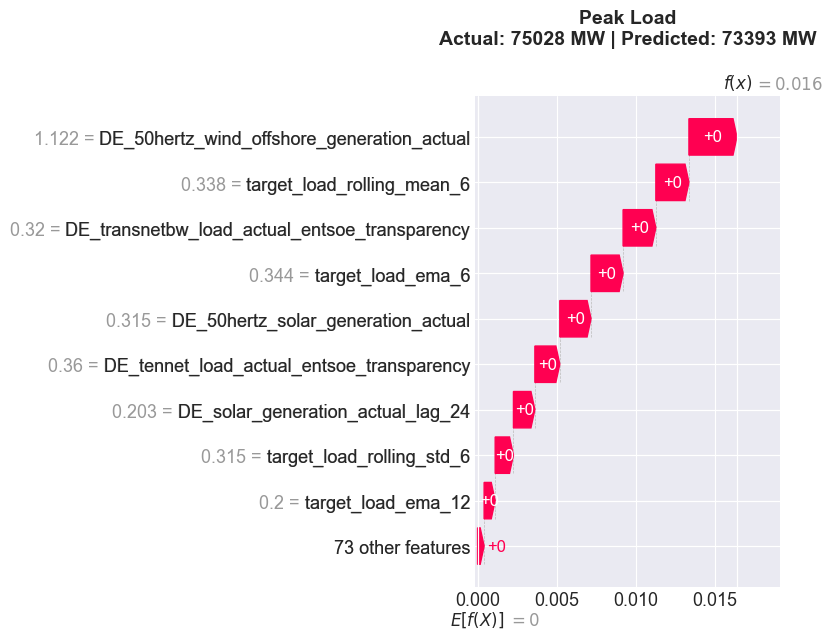

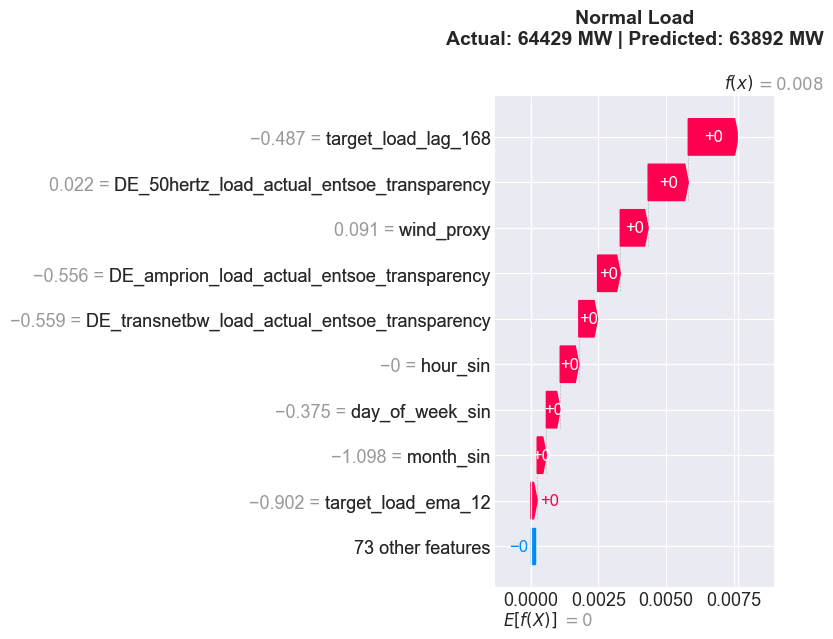

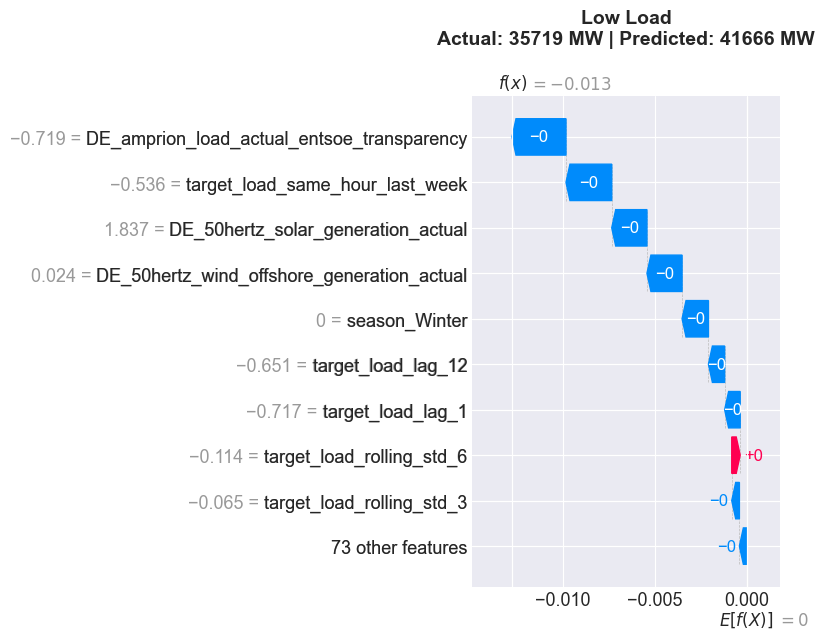

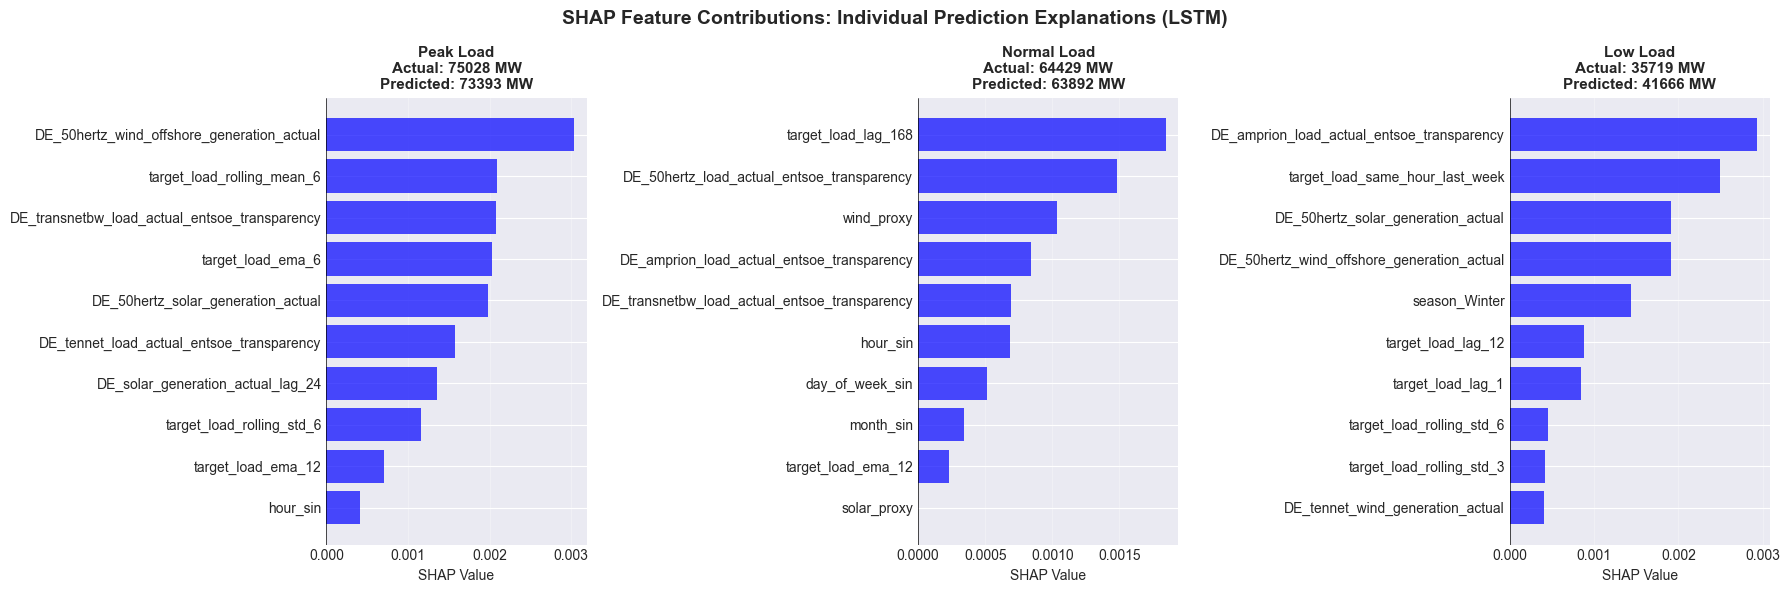

Waterfall plots saved:
  - ../../saved_model_outputs/lstm_outputs/shap_waterfall_peak_load.png
  - ../../saved_model_outputs/lstm_outputs/shap_waterfall_normal_load.png
  - ../../saved_model_outputs/lstm_outputs/shap_waterfall_low_load.png
  - ../../saved_model_outputs/lstm_outputs/shap_waterfall_plots.png (combined bar chart)


In [24]:
# 3. Waterfall Plot for Individual Predictions
# Selected : peak load, normal load, low load

print("\nGenerating SHAP waterfall plots...")


# Find interesting cases
peak_idx = np.argmax(y_test_sample)
normal_idx = len(y_test_sample) // 2
low_idx = np.argmin(y_test_sample)

interesting_cases = [
    ('Peak Load', peak_idx),
    ('Normal Load', normal_idx),
    ('Low Load', low_idx)
]

# Create individual waterfall plots
for case_name, case_idx in interesting_cases:
    actual_val = y_test_sample[case_idx]
    pred_val = y_pred_sample[case_idx]
    
    # Create SHAP Explanation object for this instance
    if 'X_test_sample_aggregated' not in locals():
        X_test_sample_aggregated = X_test_sample.mean(axis=1)
    
    exp = shap.Explanation(
        values=shap_values_signed[case_idx] if 'shap_values_signed' in locals() else shap_values_aggregated[case_idx],
        base_values=0,
        data=X_test_sample_aggregated[case_idx], 
        feature_names=feature_names
    )
    
    # Create waterfall plot
    plt.figure(figsize=(10, 8))
    shap.plots.waterfall(exp, max_display=10, show=False)
    plt.title(f'{case_name}\nActual: {actual_val:.0f} MW | Predicted: {pred_val:.0f} MW', 
              fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig(f'../../saved_model_outputs/lstm_outputs/shap_waterfall_{case_name.lower().replace(" ", "_")}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

# Create a combined bar chart version for comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (case_name, case_idx) in enumerate(interesting_cases):
    actual_val = y_test_sample[case_idx]
    pred_val = y_pred_sample[case_idx]
    
    # Get top 10 features by absolute SHAP value
    top_10_idx = np.argsort(np.abs(shap_values_aggregated[case_idx]))[-10:][::-1]
    top_10_values = shap_values_aggregated[case_idx][top_10_idx]
    top_10_names = [feature_names[i] for i in top_10_idx]
    
    # Create bar plot
    colors = ['red' if v < 0 else 'blue' for v in top_10_values]
    axes[idx].barh(range(len(top_10_values)), top_10_values, color=colors, alpha=0.7)
    axes[idx].set_yticks(range(len(top_10_names)))
    axes[idx].set_yticklabels(top_10_names)
    axes[idx].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    axes[idx].set_xlabel('SHAP Value', fontsize=10)
    axes[idx].set_title(f'{case_name}\nActual: {actual_val:.0f} MW\nPredicted: {pred_val:.0f} MW', 
                        fontsize=11, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, axis='x')
    axes[idx].invert_yaxis()

plt.suptitle('SHAP Feature Contributions: Individual Prediction Explanations (LSTM)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../../saved_model_outputs/lstm_outputs/shap_waterfall_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("Waterfall plots saved:")
print("  - ../../saved_model_outputs/lstm_outputs/shap_waterfall_peak_load.png")
print("  - ../../saved_model_outputs/lstm_outputs/shap_waterfall_normal_load.png")
print("  - ../../saved_model_outputs/lstm_outputs/shap_waterfall_low_load.png")
print("  - ../../saved_model_outputs/lstm_outputs/shap_waterfall_plots.png (combined bar chart)")



Generating SHAP bar plot...


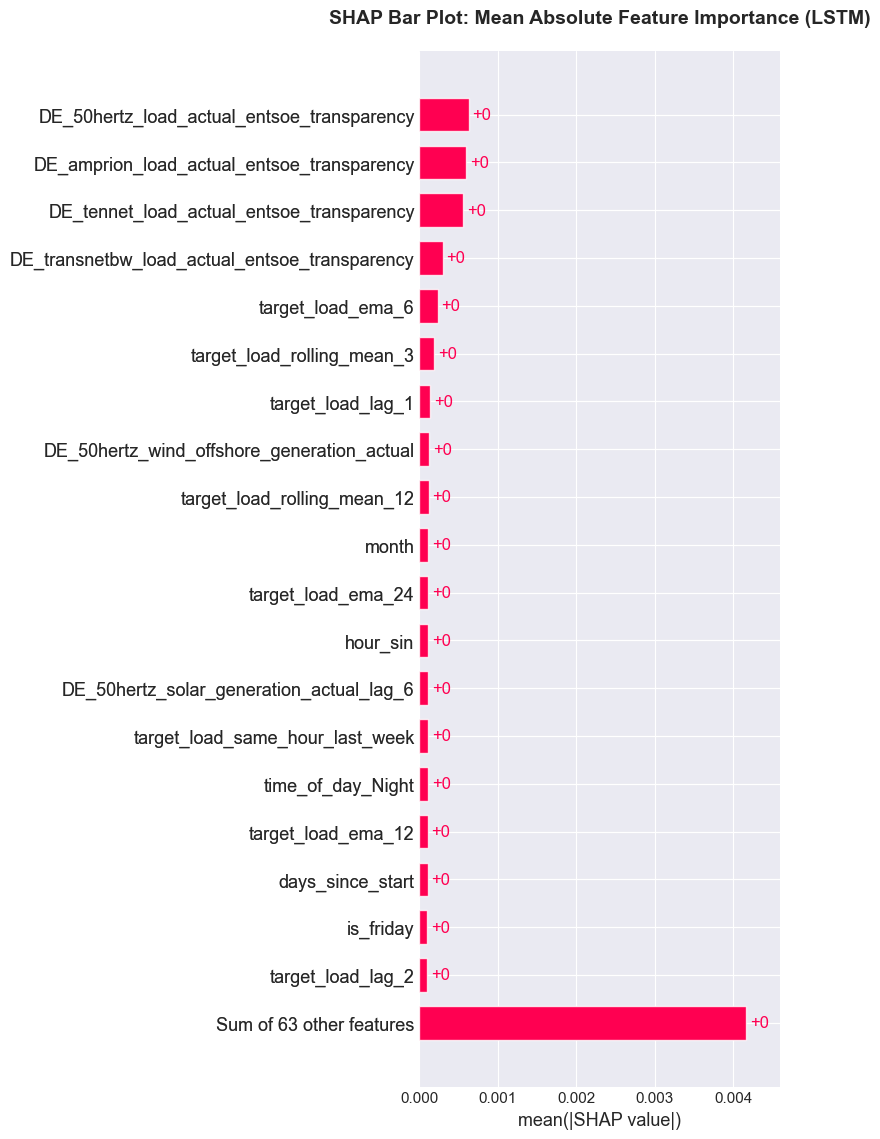

Bar plot saved to: ../../saved_model_outputs/lstm_outputs/shap_bar_plot.png
  Using aggregated data (mean across time steps) for consistency


In [25]:
# Bar Chart

print("\nGenerating SHAP bar plot...")


# Calculate mean absolute SHAP values per feature
mean_abs_shap = shap_values_aggregated.mean(axis=0)

# Create SHAP Explanation object for bar plot
shap_explanation = shap.Explanation(
    values=shap_values_signed if 'shap_values_signed' in locals() else shap_values_aggregated,
    base_values=np.zeros(len(shap_values_aggregated)), 
    data=X_test_sample_aggregated, 
    feature_names=feature_names
)

plt.figure(figsize=(10, 8))
shap.plots.bar(shap_explanation, max_display=20, show=False)
plt.title('SHAP Bar Plot: Mean Absolute Feature Importance (LSTM)', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../../saved_model_outputs/lstm_outputs/shap_bar_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("Bar plot saved to: ../../saved_model_outputs/lstm_outputs/shap_bar_plot.png")
print("  Using aggregated data (mean across time steps) for consistency")



Analyzing SHAP values for peak vs normal hours...

Peak Load SHAP Analysis Summary:
  Peak threshold: 67487 MW
  Number of peak samples: 60 (20.0%)
  Number of normal samples: 240 (80.0%)
  Mean |SHAP| for peak samples: 0.000159
  Mean |SHAP| for normal samples: 0.000084
  Peak/Normal SHAP ratio: 1.89x


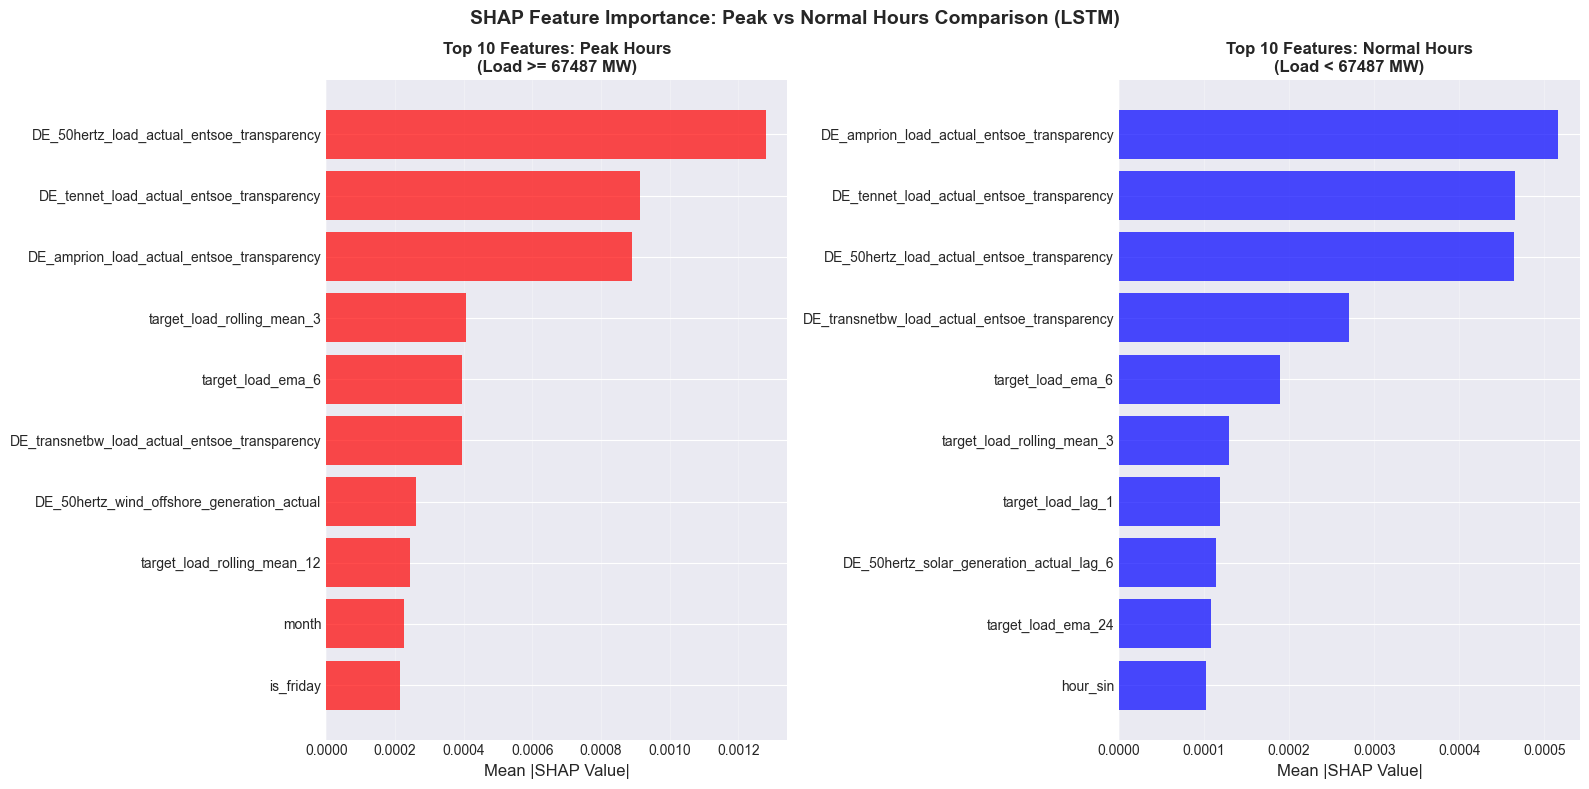

 Peak vs Normal comparison saved to: ../../saved_model_outputs/lstm_outputs/shap_peak_vs_normal.png


In [26]:
# 4. Feature Importance Comparison: Peak vs Normal Hours

print("\nAnalyzing SHAP values for peak vs normal hours...")

# Define peak hours
peak_threshold = np.percentile(y_test_sample, 80)
is_peak = y_test_sample >= peak_threshold

peak_shap = shap_values_aggregated[is_peak]
normal_shap = shap_values_aggregated[~is_peak]

# Calculate mean absolute SHAP values
peak_importance = peak_shap.mean(axis=0) 
normal_importance = normal_shap.mean(axis=0)


print(f"\nPeak Load SHAP Analysis Summary:")
print(f"  Peak threshold: {peak_threshold:.0f} MW")
print(f"  Number of peak samples: {is_peak.sum()} ({is_peak.sum()/len(is_peak)*100:.1f}%)")
print(f"  Number of normal samples: {(~is_peak).sum()} ({(~is_peak).sum()/len(is_peak)*100:.1f}%)")
print(f"  Mean |SHAP| for peak samples: {peak_importance.mean():.6f}")
print(f"  Mean |SHAP| for normal samples: {normal_importance.mean():.6f}")
print(f"  Peak/Normal SHAP ratio: {peak_importance.mean()/normal_importance.mean():.2f}x")

# Get top 10 features for each
top_n = 10
top_peak_idx = np.argsort(peak_importance)[-top_n:][::-1]
top_normal_idx = np.argsort(normal_importance)[-top_n:][::-1]

# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Peak hours
axes[0].barh(range(top_n), peak_importance[top_peak_idx], color='red', alpha=0.7)
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels([feature_names[i] for i in top_peak_idx])
axes[0].set_xlabel('Mean |SHAP Value|', fontsize=12)
axes[0].set_title(f'Top {top_n} Features: Peak Hours\n(Load >= {peak_threshold:.0f} MW)', 
                  fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].invert_yaxis()

# Normal hours
axes[1].barh(range(top_n), normal_importance[top_normal_idx], color='blue', alpha=0.7)
axes[1].set_yticks(range(top_n))
axes[1].set_yticklabels([feature_names[i] for i in top_normal_idx])
axes[1].set_xlabel('Mean |SHAP Value|', fontsize=12)
axes[1].set_title(f'Top {top_n} Features: Normal Hours\n(Load < {peak_threshold:.0f} MW)', 
                  fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].invert_yaxis()

plt.suptitle('SHAP Feature Importance: Peak vs Normal Hours Comparison (LSTM)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../../saved_model_outputs/lstm_outputs/shap_peak_vs_normal.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Peak vs Normal comparison saved to: ../../saved_model_outputs/lstm_outputs/shap_peak_vs_normal.png")



Analyzing SHAP values for weekday vs weekend...


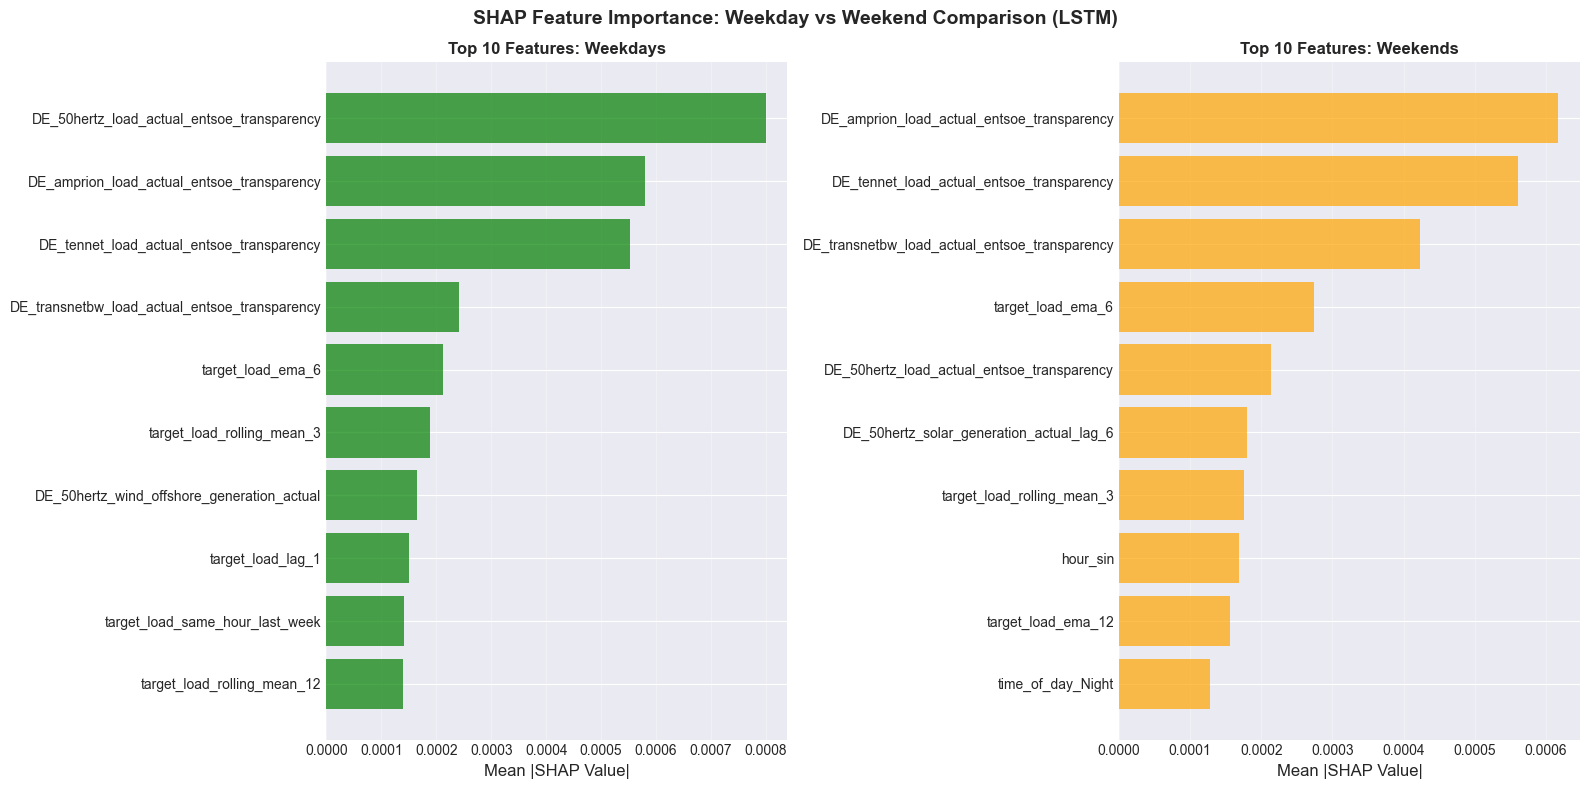

Weekday vs Weekend comparison saved to: ../../saved_model_outputs/lstm_outputs/shap_weekday_vs_weekend.png


In [27]:
# 5. Weekday vs Weekend Comparison

print("\nAnalyzing SHAP values for weekday vs weekend...")


# Extract day of week from test dates
test_dow = pd.to_datetime(test_dates_sample).dayofweek
is_weekend = (test_dow >= 5)  # Saturday=5, Sunday=6
is_weekday = (test_dow < 5)

weekday_shap = shap_values_aggregated[is_weekday]
weekend_shap = shap_values_aggregated[is_weekend]

# Calculate mean absolute SHAP values
weekday_importance = np.abs(weekday_shap).mean(axis=0)
weekend_importance = np.abs(weekend_shap).mean(axis=0)

# Get top 10 features for each
top_weekday_idx = np.argsort(weekday_importance)[-top_n:][::-1]
top_weekend_idx = np.argsort(weekend_importance)[-top_n:][::-1]

# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Weekday
axes[0].barh(range(top_n), weekday_importance[top_weekday_idx], color='green', alpha=0.7)
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels([feature_names[i] for i in top_weekday_idx])
axes[0].set_xlabel('Mean |SHAP Value|', fontsize=12)
axes[0].set_title(f'Top {top_n} Features: Weekdays', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].invert_yaxis()

# Weekend
axes[1].barh(range(top_n), weekend_importance[top_weekend_idx], color='orange', alpha=0.7)
axes[1].set_yticks(range(top_n))
axes[1].set_yticklabels([feature_names[i] for i in top_weekend_idx])
axes[1].set_xlabel('Mean |SHAP Value|', fontsize=12)
axes[1].set_title(f'Top {top_n} Features: Weekends', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].invert_yaxis()

plt.suptitle('SHAP Feature Importance: Weekday vs Weekend Comparison (LSTM)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../../saved_model_outputs/lstm_outputs/shap_weekday_vs_weekend.png', dpi=300, bbox_inches='tight')
plt.show()

print("Weekday vs Weekend comparison saved to: ../../saved_model_outputs/lstm_outputs/shap_weekday_vs_weekend.png")



Analyzing SHAP values for high error vs low error cases...


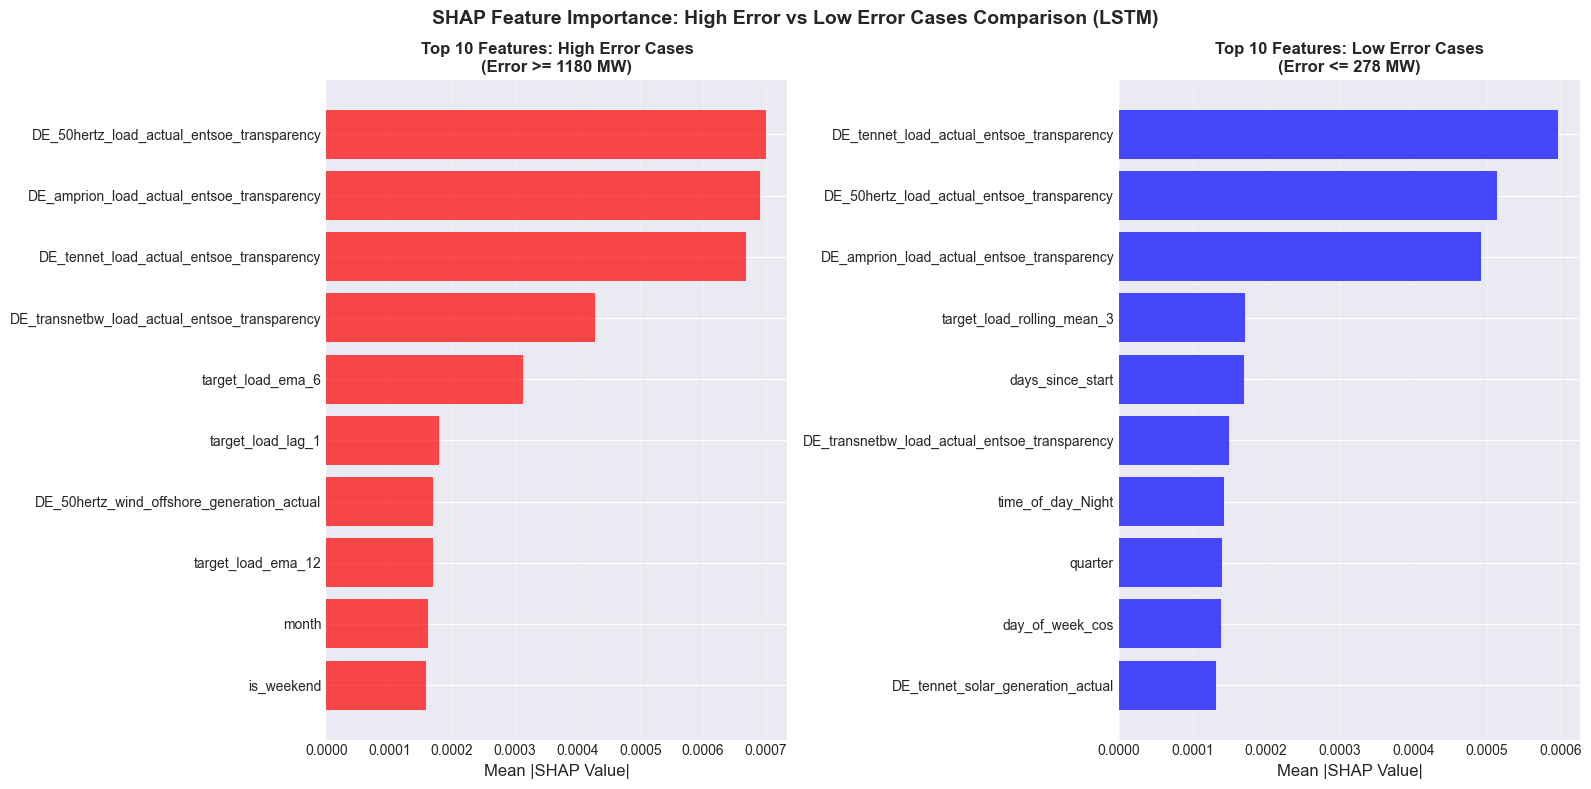

 Error analysis comparison saved to: ../../saved_model_outputs/lstm_outputs/shap_error_analysis.png


In [28]:
# 6. High Error vs Low Error Cases Comparison

print("\nAnalyzing SHAP values for high error vs low error cases...")

# Ensure required variables are defined
if 'shap_values_aggregated' not in locals():
    raise RuntimeError("Please run Cell 43 first to compute SHAP values!")
if 'y_test_sample' not in locals() or 'y_pred_sample' not in locals():
    raise RuntimeError("Please run Cell 38 first to prepare visualization data!")
if 'feature_names' not in locals():
    feature_names = feature_cols
if 'top_n' not in locals():
    top_n = 10

# Calculate errors
errors_sample = np.abs(y_test_sample - y_pred_sample)

# Define high and low error thresholds
high_error_threshold = np.percentile(errors_sample, 75)
low_error_threshold = np.percentile(errors_sample, 25)

is_high_error = errors_sample >= high_error_threshold
is_low_error = errors_sample <= low_error_threshold

high_error_shap = shap_values_aggregated[is_high_error]
low_error_shap = shap_values_aggregated[is_low_error]

# Calculate mean absolute SHAP values
high_error_importance = np.abs(high_error_shap).mean(axis=0)
low_error_importance = np.abs(low_error_shap).mean(axis=0)

# Get top 10 features for each
top_high_error_idx = np.argsort(high_error_importance)[-top_n:][::-1]
top_low_error_idx = np.argsort(low_error_importance)[-top_n:][::-1]

# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# High error cases
axes[0].barh(range(top_n), high_error_importance[top_high_error_idx], color='red', alpha=0.7)
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels([feature_names[i] for i in top_high_error_idx])
axes[0].set_xlabel('Mean |SHAP Value|', fontsize=12)
axes[0].set_title(f'Top {top_n} Features: High Error Cases\n(Error >= {high_error_threshold:.0f} MW)', 
                  fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].invert_yaxis()

# Low error cases
axes[1].barh(range(top_n), low_error_importance[top_low_error_idx], color='blue', alpha=0.7)
axes[1].set_yticks(range(top_n))
axes[1].set_yticklabels([feature_names[i] for i in top_low_error_idx])
axes[1].set_xlabel('Mean |SHAP Value|', fontsize=12)
axes[1].set_title(f'Top {top_n} Features: Low Error Cases\n(Error <= {low_error_threshold:.0f} MW)', 
                  fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].invert_yaxis()

plt.suptitle('SHAP Feature Importance: High Error vs Low Error Cases Comparison (LSTM)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../../saved_model_outputs/lstm_outputs/shap_error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Error analysis comparison saved to: ../../saved_model_outputs/lstm_outputs/shap_error_analysis.png")



Generating SHAP heatmap for time series...


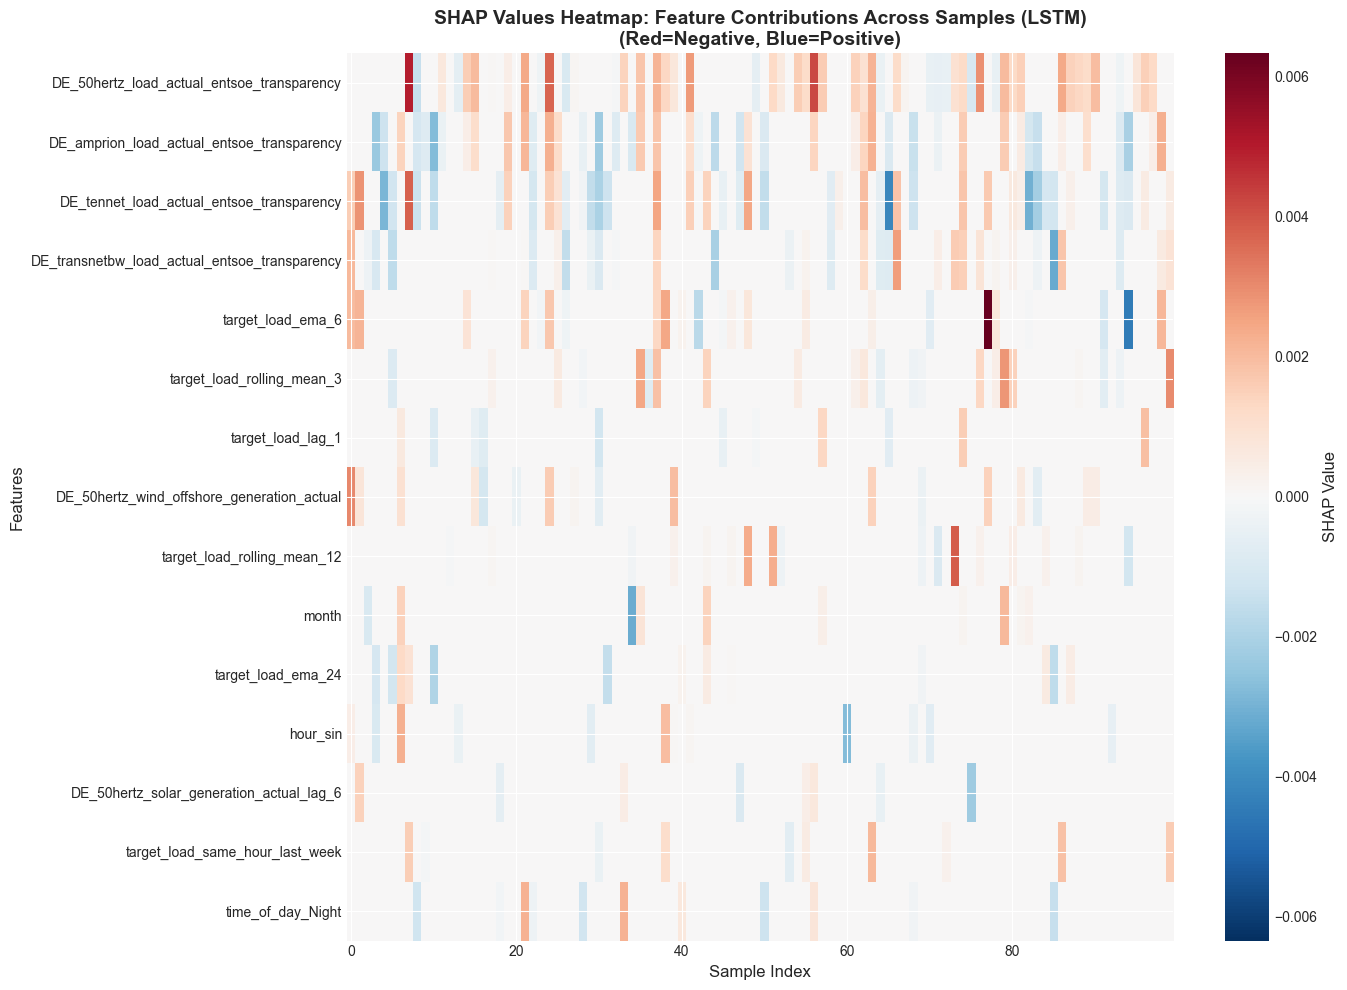

Heatmap saved to: ../../saved_model_outputs/lstm_outputs/shap_heatmap.png


In [29]:
# 7. Heatmap of SHAP values for time series

print("\nGenerating SHAP heatmap for time series...")

# Select a subset of test samples (e.g., first 100)
n_samples_heatmap = min(100, len(test_indices))
heatmap_indices = np.arange(n_samples_heatmap)

# Get top features by mean absolute SHAP value
top_features_heatmap = np.argsort(shap_values_aggregated.mean(axis=0))[-15:][::-1]
top_feature_names = [feature_names[i] for i in top_features_heatmap]

# FIXED: Use signed SHAP values for better visualization
shap_values_for_heatmap = shap_values_signed if 'shap_values_signed' in locals() else shap_values_aggregated
shap_heatmap_data = shap_values_for_heatmap[:n_samples_heatmap, top_features_heatmap]

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 10))
im = ax.imshow(shap_heatmap_data.T, aspect='auto', cmap='RdBu_r', 
               vmin=-np.abs(shap_heatmap_data).max(), 
               vmax=np.abs(shap_heatmap_data).max())

ax.set_yticks(range(len(top_feature_names)))
ax.set_yticklabels(top_feature_names)
ax.set_xlabel('Sample Index', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.set_title('SHAP Values Heatmap: Feature Contributions Across Samples (LSTM)\n(Red=Negative, Blue=Positive)', 
             fontsize=14, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('SHAP Value', fontsize=12)

plt.tight_layout()
plt.savefig('../../saved_model_outputs/lstm_outputs/shap_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Heatmap saved to: ../../saved_model_outputs/lstm_outputs/shap_heatmap.png")




Analyzing SHAP values by time of day...
Hours represented in sample: 24 out of 24
Hours present: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23)]


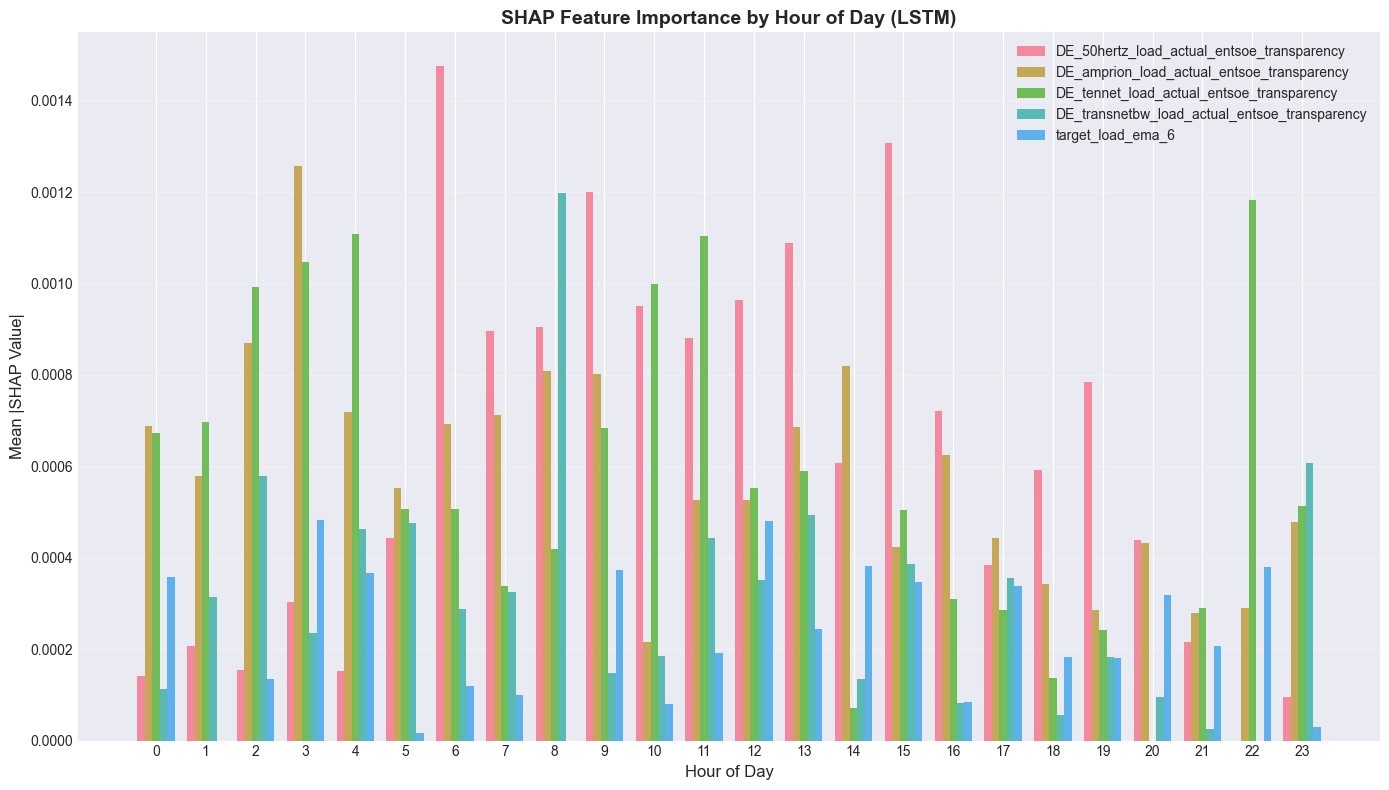

Hourly analysis saved to: ../../saved_model_outputs/lstm_outputs/shap_by_hour.png


In [30]:
# 8. Feature Importance by Time of Day

print("\nAnalyzing SHAP values by time of day...")


# Extract hour from test dates
test_hours = pd.to_datetime(test_dates_sample).hour.values

# Check hour distribution
unique_hours = np.unique(test_hours)
print(f"Hours represented in sample: {len(unique_hours)} out of 24")
print(f"Hours present: {sorted(unique_hours)}")
if len(unique_hours) < 24:
    missing_hours = set(range(24)) - set(unique_hours)
    print(f"⚠️  WARNING: Missing hours: {sorted(missing_hours)}")
    print(f"   This may be due to random sampling. Consider using more samples or stratified sampling.")

# Group by hour
hourly_shap = {}
for hour in range(24):
    hour_mask = test_hours == hour
    if hour_mask.sum() > 0:
        hourly_shap[hour] = np.abs(shap_values_aggregated[hour_mask]).mean(axis=0)
    else:
        # Fill missing hours with zeros or NaN to show all 24 hours
        hourly_shap[hour] = np.zeros(shap_values_aggregated.shape[1])

# Get top 5 features overall
top_5_features_idx = np.argsort(np.abs(shap_values_aggregated).mean(axis=0))[-5:][::-1]
top_5_feature_names = [feature_names[i] for i in top_5_features_idx]

# Create plot
fig, ax = plt.subplots(figsize=(14, 8))

# Use all 24 hours for consistent x-axis (even if some have zero values)
hours_list = list(range(24))
x = np.arange(len(hours_list))
width = 0.15

for idx, feat_idx in enumerate(top_5_features_idx):
    values = [hourly_shap[h][feat_idx] for h in hours_list]
    # Use different alpha for hours with no data
    alphas = [0.8 if h in unique_hours else 0.2 for h in hours_list]
    ax.bar(x + idx * width, values, width, label=feature_names[feat_idx], alpha=0.8)

ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Mean |SHAP Value|', fontsize=12)
title = 'SHAP Feature Importance by Hour of Day (LSTM)'
if len(unique_hours) < 24:
    title += f'\n(Only {len(unique_hours)} hours have data)'
ax.set_title(title, fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(hours_list)
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../../saved_model_outputs/lstm_outputs/shap_by_hour.png', dpi=300, bbox_inches='tight')
plt.show()

print("Hourly analysis saved to: ../../saved_model_outputs/lstm_outputs/shap_by_hour.png")


In [31]:
# 9. Summary Statistics and Feature Importance Table

print("\n" + "="*80)
print("SHAP Feature Importance Summary")
print("="*80)

# Ensure required variables are defined
if 'shap_values_aggregated' not in locals():
    raise RuntimeError("Please run Cell 43 first to compute SHAP values!")
if 'feature_names' not in locals():
    feature_names = feature_cols
if 'background_size' not in locals():
    background_size = min(100, len(X_train_seq)) if 'X_train_seq' in locals() else 50
if 'test_sample_size' not in locals():
    test_sample_size = len(test_indices) if 'test_indices' in locals() else 300
if 'y_test_sample' not in locals() or 'y_pred_sample' not in locals():
    raise RuntimeError("Please run Cell 38 first to prepare visualization data!")

# Calculate mean absolute SHAP values
mean_abs_shap = shap_values_aggregated.mean(axis=0)

shap_signed_for_stats = shap_values_signed if 'shap_values_signed' in locals() else shap_values_aggregated

# Create importance dataframe
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean_|SHAP|': mean_abs_shap,
    'Mean_SHAP': shap_signed_for_stats.mean(axis=0),  
    'Std_SHAP': shap_signed_for_stats.std(axis=0)  
}).sort_values('Mean_|SHAP|', ascending=False)

print("\nTop 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))

# Save to CSV
importance_df.to_csv('../../saved_model_outputs/lstm_outputs/shap_feature_importance.csv', index=False)
print(f"\n Feature importance table saved to: ../../saved_model_outputs/lstm_outputs/shap_feature_importance.csv")

# Summary statistics
print("\n" + "="*80)
print("SHAP Analysis Summary Statistics")
print("="*80)
print(f"Total features analyzed: {len(feature_names)}")
print(f"Background samples: {background_size}")
print(f"Test samples analyzed: {test_sample_size}")
print(f"Mean prediction: {y_pred_sample.mean():.2f} MW")
print(f"Mean actual: {y_test_sample.mean():.2f} MW")
print(f"\nTop 5 most important features:")
for i, row in importance_df.head(5).iterrows():
    print(f"  {i+1}. {row['Feature']}: {row['Mean_|SHAP|']:.4f}")



SHAP Feature Importance Summary

Top 20 Most Important Features:
                                      Feature  Mean_|SHAP|  Mean_SHAP  Std_SHAP
   DE_50hertz_load_actual_entsoe_transparency     0.000628   0.000473  0.001013
   DE_amprion_load_actual_entsoe_transparency     0.000591   0.000011  0.001007
    DE_tennet_load_actual_entsoe_transparency     0.000555  -0.000086  0.001026
DE_transnetbw_load_actual_entsoe_transparency     0.000295  -0.000054  0.000707
                            target_load_ema_6     0.000231   0.000008  0.000761
                   target_load_rolling_mean_3     0.000184   0.000060  0.000531
                            target_load_lag_1     0.000137   0.000028  0.000457
   DE_50hertz_wind_offshore_generation_actual     0.000123   0.000040  0.000418
                  target_load_rolling_mean_12     0.000117   0.000038  0.000423
                                        month     0.000114   0.000026  0.000403
                           target_load_ema_24     0.00


Generating partial dependence plots for top features...


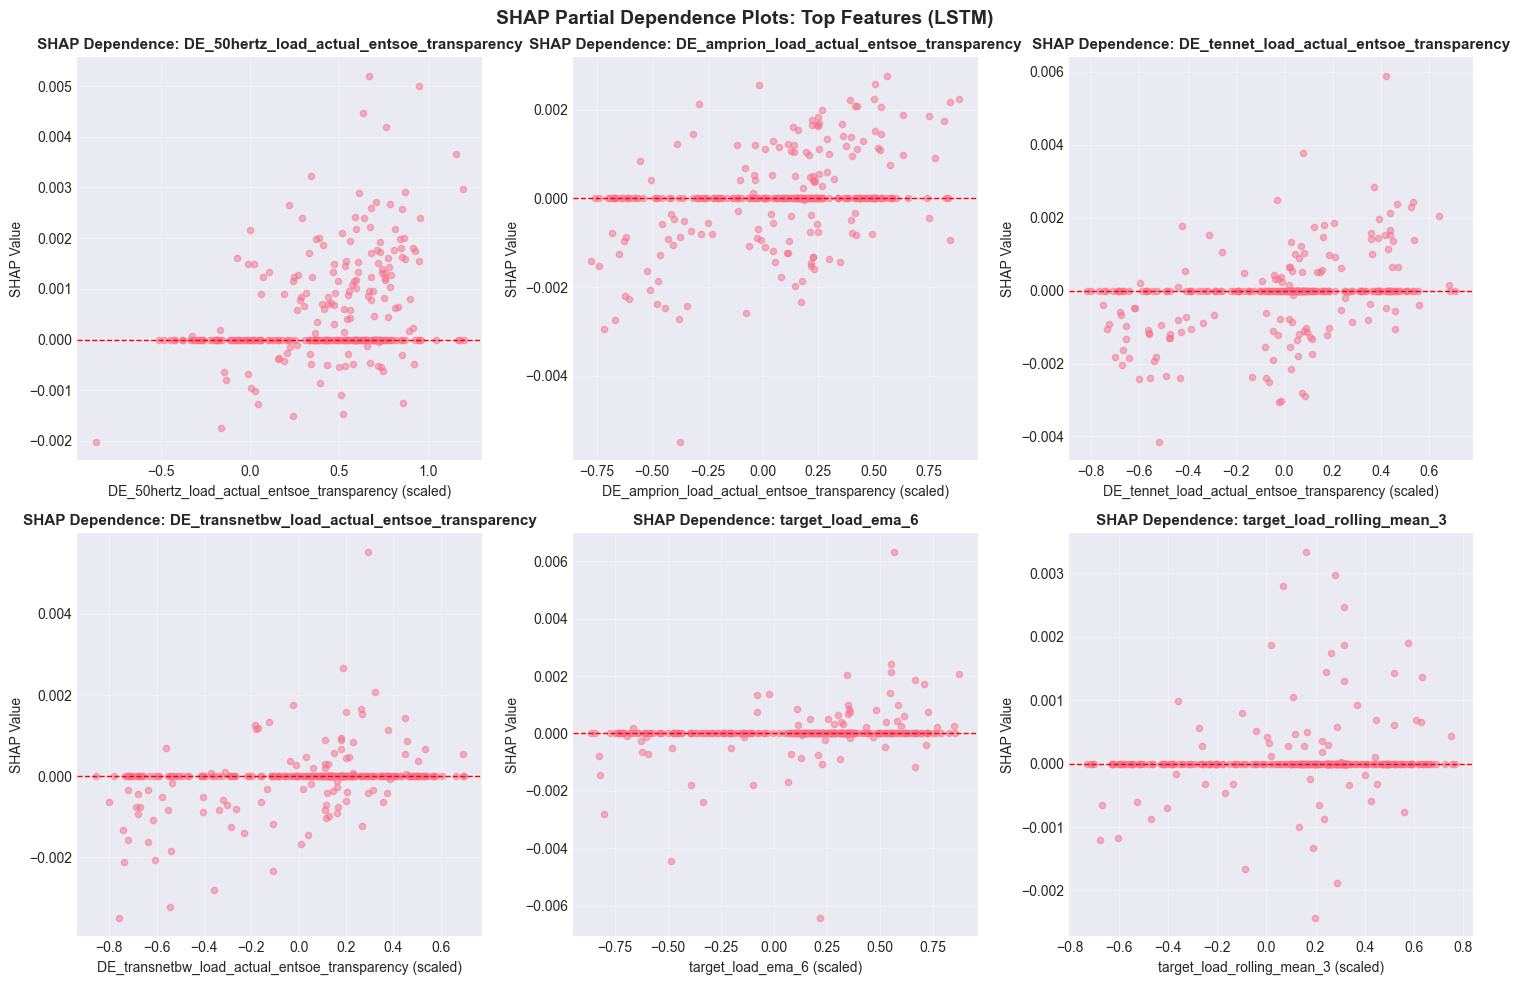

Partial dependence plots saved to: ../../saved_model_outputs/lstm_outputs/shap_partial_dependence.png


In [32]:
# 10. Partial Dependence Plots for Top Features

print("\nGenerating partial dependence plots for top features...")

# Ensure required variables are defined
if 'importance_df' not in locals():
    raise RuntimeError("Please run Cell 56 first to create importance dataframe!")
if 'feature_names' not in locals():
    feature_names = feature_cols
if 'X_test_sample' not in locals():
    raise RuntimeError("Please run Cell 38 first to prepare test samples!")
if 'shap_values_aggregated' not in locals():
    raise RuntimeError("Please run Cell 43 first to compute SHAP values!")

top_features_pdp = importance_df.head(6)['Feature'].values

n_cols = 3
n_rows = (len(top_features_pdp) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if len(top_features_pdp) > 1 else [axes]

for idx, feat_name in enumerate(top_features_pdp):
    feat_idx = feature_names.index(feat_name)
    
    
    if 'X_test_sample_aggregated' not in locals():
        X_test_sample_aggregated = X_test_sample.mean(axis=1)
    feat_values = X_test_sample_aggregated[:, feat_idx]  
    shap_vals = shap_values_signed[:, feat_idx] if 'shap_values_signed' in locals() else shap_values_aggregated[:, feat_idx]
    
    # Create scatter plot
    axes[idx].scatter(feat_values, shap_vals, alpha=0.5, s=20)
    axes[idx].axhline(y=0, color='r', linestyle='--', linewidth=1)
    axes[idx].set_xlabel(f'{feat_name} (scaled)', fontsize=10)
    axes[idx].set_ylabel('SHAP Value', fontsize=10)
    axes[idx].set_title(f'SHAP Dependence: {feat_name}', fontsize=11, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(len(top_features_pdp), len(axes)):
    axes[idx].axis('off')

plt.suptitle('SHAP Partial Dependence Plots: Top Features (LSTM)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../../saved_model_outputs/lstm_outputs/shap_partial_dependence.png', dpi=300, bbox_inches='tight')
plt.show()

print("Partial dependence plots saved to: ../../saved_model_outputs/lstm_outputs/shap_partial_dependence.png")


In [33]:
# 11. Save SHAP values

print("\nSaving SHAP values...")

# Ensure required variables are defined
if 'shap_values_aggregated' not in locals():
    raise RuntimeError("Please run Cell 43 first to compute SHAP values!")
if 'feature_names' not in locals():
    feature_names = feature_cols
if 'test_dates_sample' not in locals():
    raise RuntimeError("Please run Cell 38 first to prepare visualization data!")
if 'y_test_sample' not in locals() or 'y_pred_sample' not in locals():
    raise RuntimeError("Please run Cell 38 first to prepare visualization data!")

# Create DataFrame with SHAP values
shap_df = pd.DataFrame(
    shap_values_aggregated,
    columns=[f'SHAP_{name}' for name in feature_names],
    index=test_dates_sample
)

# Add actual and predicted values
shap_df['actual'] = y_test_sample
shap_df['predicted'] = y_pred_sample
shap_df['error'] = y_test_sample - y_pred_sample
shap_df['abs_error'] = np.abs(shap_df['error'])

# Add metadata
shap_df['is_peak'] = y_test_sample >= np.percentile(y_test_sample, 90)
shap_df['hour'] = pd.to_datetime(test_dates_sample).hour
shap_df['day_of_week'] = pd.to_datetime(test_dates_sample).dayofweek

# Save to CSV
shap_df.to_csv('../../saved_model_outputs/lstm_outputs/shap_values.csv')
print("✓ SHAP values saved to: ../../saved_model_outputs/lstm_outputs/shap_values.csv")

print("\n" + "="*80)
print("SHAP ANALYSIS COMPLETE!")
print("="*80)
print("\nGenerated visualizations:")
print("  1. shap_summary_plot.png - Global feature importance")
print("  2. shap_bar_plot.png - Mean absolute SHAP values")
print("  3. shap_waterfall_plots.png - Individual prediction explanations")
print("  4. shap_peak_vs_normal.png - Peak vs normal hours comparison")
print("  5. shap_weekday_vs_weekend.png - Weekday vs weekend comparison")
print("  6. shap_error_analysis.png - High error vs low error cases comparison")
print("  7. shap_heatmap.png - Feature contributions across samples")
print("  8. shap_by_hour.png - Feature importance by hour of day")
print("  9. shap_partial_dependence.png - Partial dependence plots")
print("\nGenerated data files:")
print("  1. shap_feature_importance.csv - Feature importance table")
print("  2. shap_values.csv - SHAP values for all samples")
print("="*80)



Saving SHAP values...
✓ SHAP values saved to: ../../saved_model_outputs/lstm_outputs/shap_values.csv

SHAP ANALYSIS COMPLETE!

Generated visualizations:
  1. shap_summary_plot.png - Global feature importance
  2. shap_bar_plot.png - Mean absolute SHAP values
  3. shap_waterfall_plots.png - Individual prediction explanations
  4. shap_peak_vs_normal.png - Peak vs normal hours comparison
  5. shap_weekday_vs_weekend.png - Weekday vs weekend comparison
  6. shap_error_analysis.png - High error vs low error cases comparison
  7. shap_heatmap.png - Feature contributions across samples
  8. shap_by_hour.png - Feature importance by hour of day
  9. shap_partial_dependence.png - Partial dependence plots

Generated data files:
  1. shap_feature_importance.csv - Feature importance table
  2. shap_values.csv - SHAP values for all samples
